In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from time import time
from scipy.stats import norm
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import regularizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from nn_models import *

import pickle
import plotly.plotly as py
import plotly.graph_objs as go
import plotly
import colorlover as cl
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML
from utils import *
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
__date__ = '2017-08-04'
%matplotlib inline
HTML('''<script> code_show_err=false;  function code_toggle_err() {if (code_show_err){$('div.output_stderr').hide();} else {$('div.output_stderr').show();}code_show_err = !code_show_err} $( document ).ready(code_toggle_err);</script>To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

Using TensorFlow backend.


/home/asturkmani/Thesis-Old/utils.py:253: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



(41178, 6, 1) (41178,) (41178, 6, 1) (41178,) (41178, 6, 1) (41178,)
Dataset size: (18200, 15) 

Number of apps that consume 90.0 % of all users time:  15 



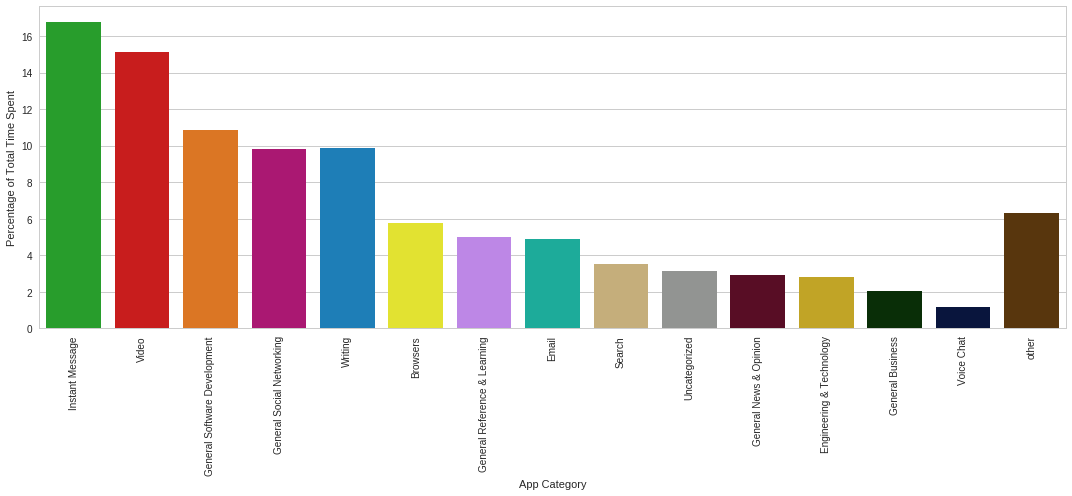

In [13]:
window_size = 6
batch_size = 100
data_ = make_clean_data(window_size, batch_size,multiplier=1)

time_percentage=0.9
time_spent = data_['dataset'].sum(axis=0)/data_['dataset'].sum()*100

print("Dataset size:", data_['yc'].shape,'\n')
print("Number of apps that consume", time_percentage*100, "% of all users time: ",len(data_['popular_apps']), '\n')

# app_colors = ['green','red', 'orange', 'magenta','cerulean', 'yellow', 'light purple', 'turquoise', 'tan', 'grey', 'maroon', 'gold', 'dark green', 'navy blue', 'brown']
# col_list_palette = sns.xkcd_palette(app_colors)
app_stats = pd.DataFrame.from_dict({'app' : data_['popular_apps'],'time_spent' : time_spent.tolist(),'colors' : data_['data_colors']})

sns.set_style("whitegrid")
plt.figure(figsize=(15,7))
plt.xticks(rotation=90)
ax = sns.barplot(x='app', y='time_spent', data=app_stats, palette=data_['data_colors'])
plt.xlabel(s='App Category')
plt.ylabel(s='Percentage of Total Time Spent')
plt.tight_layout()
plt.savefig('TimeSpentDistribution.png', format='png', dpi=1000)

# PCA

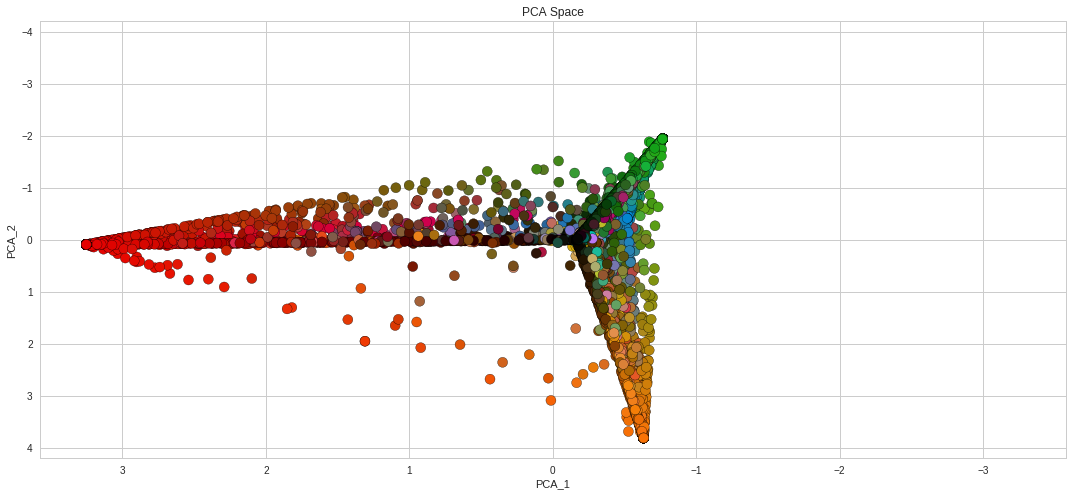

In [4]:
data_pca = PCA(n_components=2, whiten=True)
data_pca = data_pca.fit_transform(data_['yc'])
x = data_pca[:,0]
y = data_pca[:,1]
x_max = max(abs(x))*1.1
y_max = max(abs(y))*1.1
yc_colz = [tuple(x) for x in data_['yc_colors'].tolist()]
fig = plt.figure(figsize=(15,7))
plt.scatter(x=x, y=y, c=yc_colz, s=100, edgecolors='black')
plt.xlim([x_max, -x_max])
plt.ylim([y_max, -y_max])
# plt.autoscale()
plt.title('PCA Space')
plt.xlabel('PCA_1')
plt.ylabel('PCA_2')
plt.tight_layout()
plt.savefig('PCA.png', format='png', dpi=1000)

# VAE

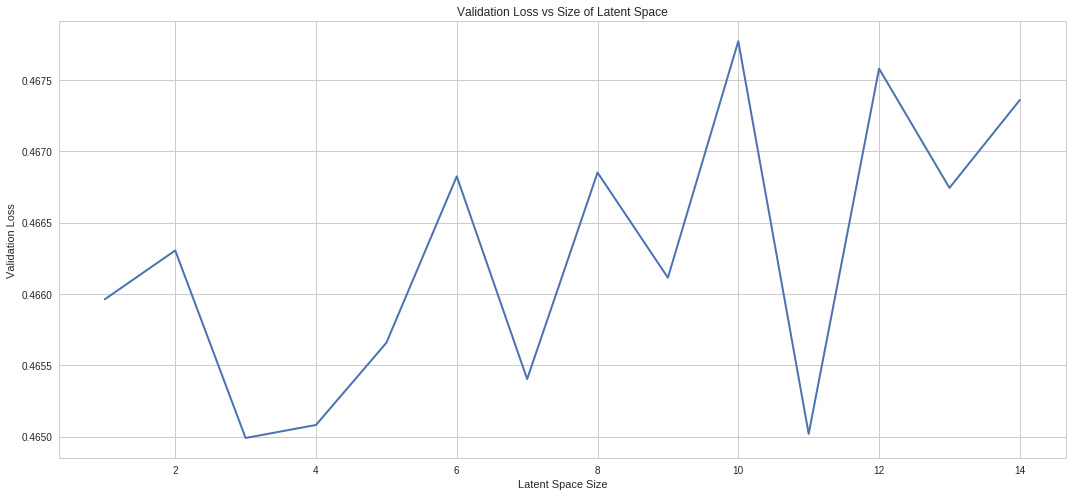

In [7]:
losses = list()
for n_z in range(1,15):
    vae, encoder, generator = build_vae(original_dim,batch_size = batch_size,latent_dim = n_z,intermediate_dim = 0,activ='elu',optim=RMSprop(),epsilon_std=1.)
    vae_hist = vae.fit(x=data_['y_train_c'], y=data_['y_train_c'],verbose = 0,batch_size=batch_size,epochs=epochs,validation_data = (data_['y_test_c'],data_['y_test_c']),callbacks = [EarlyStopping(patience = 5)])
    losses.append(min(vae_hist.history['val_loss']))
    
    
x = np.arange(len(losses))+1
fig = plt.figure(figsize=(15,7))
linewidth=2
linetype = '-'
plt.plot(x, losses, linetype, linewidth=linewidth)
# plt.autoscale()
plt.title('Validation Loss vs Size of Latent Space')
plt.xlabel('Latent Space Size')
plt.ylabel('Validation Loss')
plt.tight_layout()
plt.savefig('VAE_latent_size_loss.png', format='png', dpi=1000)

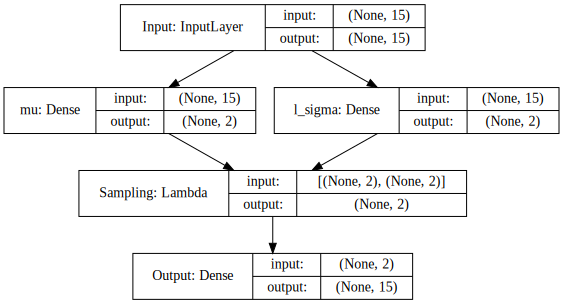

In [14]:
original_dim = data_['x_train_c'].shape[-1]

time_dim = data_['time']
days_dim = data_['days']
latent_dim = 2
intermediate_dim = 0
epochs = 100
batch_size = 100

vae, encoder, generator = build_vae(original_dim,
              batch_size = batch_size,
              latent_dim = latent_dim,
              intermediate_dim = 0,
              activ='elu',
              optim=RMSprop(),
              epsilon_std=1.)
# print(vae.summary())
plot_model(vae, to_file='vae.png', show_shapes=True, show_layer_names=True)
SVG(model_to_dot(vae, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

Train on 14600 samples, validate on 3600 samples
Epoch 1/100
0s - loss: 3.1851 - KL_loss: 0.0497 - recon_loss: 3.1354 - val_loss: 2.0630 - val_KL_loss: 0.0903 - val_recon_loss: 1.9727
Epoch 2/100
0s - loss: 1.3100 - KL_loss: 0.0526 - recon_loss: 1.2574 - val_loss: 1.0200 - val_KL_loss: 0.1132 - val_recon_loss: 0.9067
Epoch 3/100
0s - loss: 0.6477 - KL_loss: 0.0597 - recon_loss: 0.5881 - val_loss: 0.6306 - val_KL_loss: 0.0696 - val_recon_loss: 0.5610
Epoch 4/100
0s - loss: 0.4098 - KL_loss: 0.0200 - recon_loss: 0.3898 - val_loss: 0.4871 - val_KL_loss: 0.0203 - val_recon_loss: 0.4668
Epoch 5/100
0s - loss: 0.3607 - KL_loss: 0.0036 - recon_loss: 0.3571 - val_loss: 0.4721 - val_KL_loss: 0.0055 - val_recon_loss: 0.4666
Epoch 6/100
0s - loss: 0.3577 - KL_loss: 7.4271e-04 - recon_loss: 0.3570 - val_loss: 0.4704 - val_KL_loss: 0.0013 - val_recon_loss: 0.4691
Epoch 7/100
0s - loss: 0.3571 - KL_loss: 1.9241e-04 - recon_loss: 0.3569 - val_loss: 0.4659 - val_KL_loss: 1.2851e-04 - val_recon_loss: 0

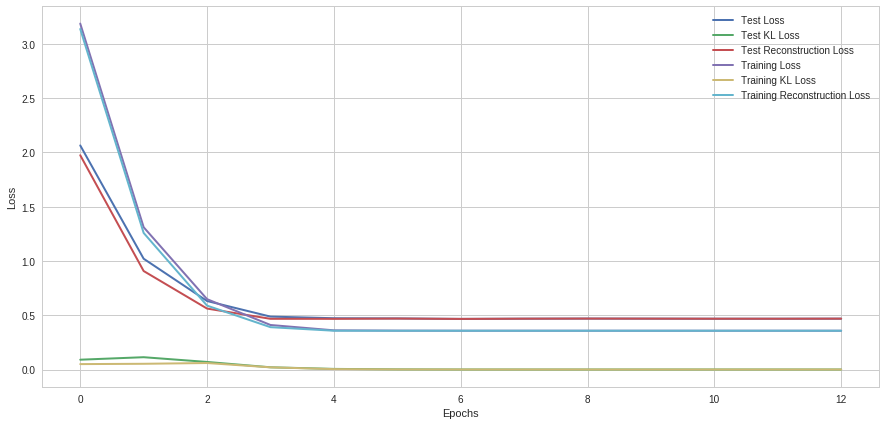

In [15]:
# tensorboard = TensorBoard(log_dir='./logs', histogram_freq=2, batch_size=batch_size, write_graph=True, write_grads=True, write_images=True, embeddings_freq=0)
vae_hist = vae.fit(x=data_['y_train_c'], 
                   y=data_['y_train_c'],
                   verbose = 2,
                   batch_size=batch_size,
                   epochs=epochs,
                   validation_data = (
                       data_['y_test_c'],
                       data_['y_test_c']),
                   callbacks = [
                       EarlyStopping(patience = 5)]
                  )
z_train = encoder.predict(data_['yc'], batch_size=batch_size)
encodings= np.asarray(z_train)
encodings = encodings.reshape(data_['yc'].shape[0], latent_dim)


print(min(vae_hist.history['val_loss']))
fig = plt.figure(figsize=(15,7))
x = np.arange(len(vae_hist.history['val_loss']))
linewidth=2
linetype = '-'
plt.plot(x, vae_hist.history['val_loss'], linetype, linewidth=linewidth, label='Test Loss')
plt.plot(x, vae_hist.history['val_KL_loss'], linetype, linewidth=linewidth, label = 'Test KL Loss')
plt.plot(x, vae_hist.history['val_recon_loss'], linetype, linewidth=linewidth, label='Test Reconstruction Loss')
plt.plot(x, vae_hist.history['loss'], linetype, linewidth=linewidth, label='Training Loss')
plt.plot(x, vae_hist.history['KL_loss'], linetype, linewidth=linewidth, label='Training KL Loss')
plt.plot(x, vae_hist.history['recon_loss'], linetype, linewidth=linewidth, label='Training Reconstruction Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('VAE Losses.png', format='png', dpi=1000)

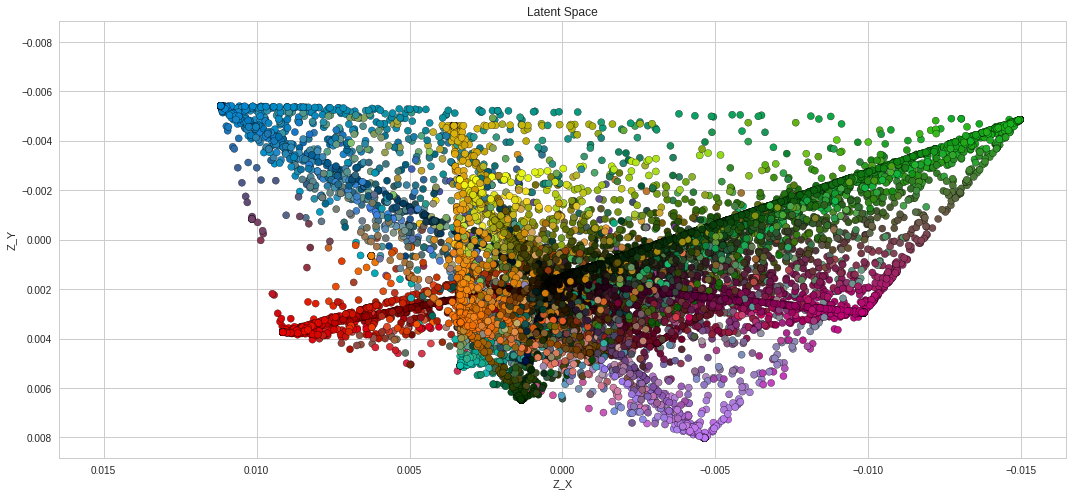

In [73]:
x = encodings[:,0]
y = encodings[:,1]
x_max = max(abs(x))*1.1
y_max = max(abs(y))*1.1
yc_colz = [tuple(x) for x in data_['yc_colors'].tolist()]
fig = plt.figure(figsize=(15,7))
plt.scatter(x=x, y=y, c=yc_colz, s=50, edgecolors='black')
plt.xlim([x_max, -x_max])
plt.ylim([y_max, -y_max])
# plt.autoscale()
plt.title('Latent Space')
plt.xlabel('Z_X')
plt.ylabel('Z_Y')
plt.tight_layout()
plt.savefig('VAE_Latent_Space3.png', format='png', dpi=1000)

# Conditional VAE with Time & Day

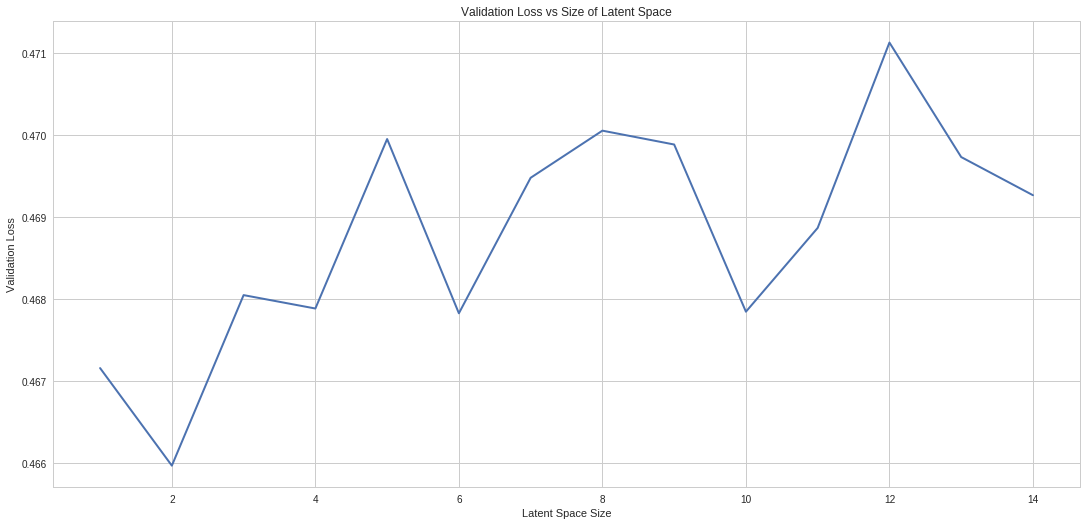

In [74]:
losses = list()
for n_z in range(1,15):
    c_vae, c_encoder, c_generator =  buid_cvae(original_dim,
              batch_size = batch_size,
              latent_dim = n_z,
              intermediate_dim = 0,
              activ='relu',
              optim=RMSprop(),
              epsilon_std=1.,
              time_dim=24,
              day_dim=7)
    c_vae_hist = c_vae.fit([data_['y_train_c'], to_categorical(data_['y_train_d']), to_categorical(data_['y_train_t'])], 
                            data_['y_train_c'], 
                            verbose = 0, 
                            batch_size=batch_size, 
                            epochs=epochs,
                            validation_data = (
                                [data_['y_test_c'], to_categorical(data_['y_test_d']),to_categorical(data_['y_test_t'])], 
                                data_['y_test_c']),
                            callbacks = [EarlyStopping(patience = 5)])
    losses.append(min(c_vae_hist.history['val_loss']))
    
    
x = np.arange(len(losses))+1
fig = plt.figure(figsize=(15,7))
linewidth=2
linetype = '-'
plt.plot(x, losses, linetype, linewidth=linewidth)
# plt.autoscale()
plt.tight_layout()
plt.title('Validation Loss vs Size of Latent Space')
plt.xlabel('Latent Space Size')
plt.ylabel('Validation Loss')
plt.savefig('c_VAE_latent_size_loss.png', format='png', dpi=1000)

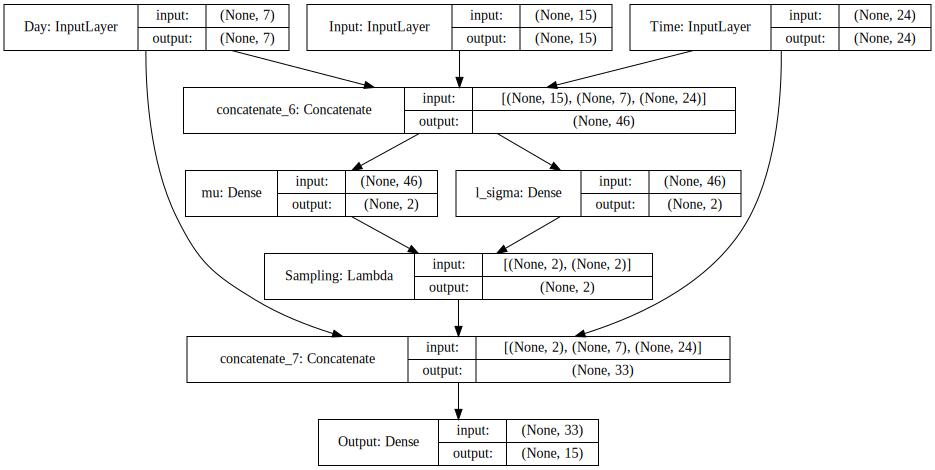

In [11]:
c_vae, c_encoder, c_generator =  buid_cvae(original_dim,
              batch_size = batch_size,
              latent_dim = 2,
              intermediate_dim = 0,
              activ='relu',
              optim='adam',
              epsilon_std=1.,
              time_dim=24,
              day_dim=7)
# print(c_vae.summary())
plot_model(c_vae, to_file='c_vae.png', show_shapes=True, show_layer_names=True)
SVG(model_to_dot(c_vae, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

0.468329966068


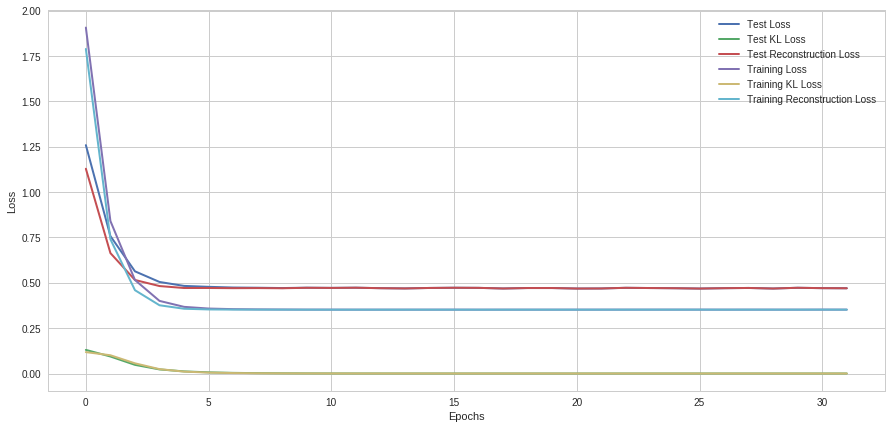

In [16]:
# compile and fit
c_vae_hist = c_vae.fit([data_['y_train_c'], to_categorical(data_['y_train_d']), to_categorical(data_['y_train_t'])], 
                            data_['y_train_c'], 
                            verbose = 0, 
                            batch_size=batch_size, 
                            epochs=epochs,
                            validation_data = (
                                [data_['y_test_c'], to_categorical(data_['y_test_d']),to_categorical(data_['y_test_t'])], 
                                data_['y_test_c']),
                            callbacks = [EarlyStopping(patience = 5)])


print(min(c_vae_hist.history['val_loss']))
fig = plt.figure(figsize=(15,7))
x = np.arange(len(c_vae_hist.history['val_loss']))
linewidth=2
linetype = '-'
plt.plot(x, c_vae_hist.history['val_loss'], linetype, linewidth=linewidth, label='Test Loss')
plt.plot(x, c_vae_hist.history['val_KL_loss'], linetype, linewidth=linewidth, label = 'Test KL Loss')
plt.plot(x, c_vae_hist.history['val_recon_loss'], linetype, linewidth=linewidth, label='Test Reconstruction Loss')
plt.plot(x, c_vae_hist.history['loss'], linetype, linewidth=linewidth, label='Training Loss')
plt.plot(x, c_vae_hist.history['KL_loss'], linetype, linewidth=linewidth, label='Training KL Loss')
plt.plot(x, c_vae_hist.history['recon_loss'], linetype, linewidth=linewidth, label='Training Reconstruction Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('C_VAE_TD_Losses.png', format='png', dpi=1000)

(18200, 2)


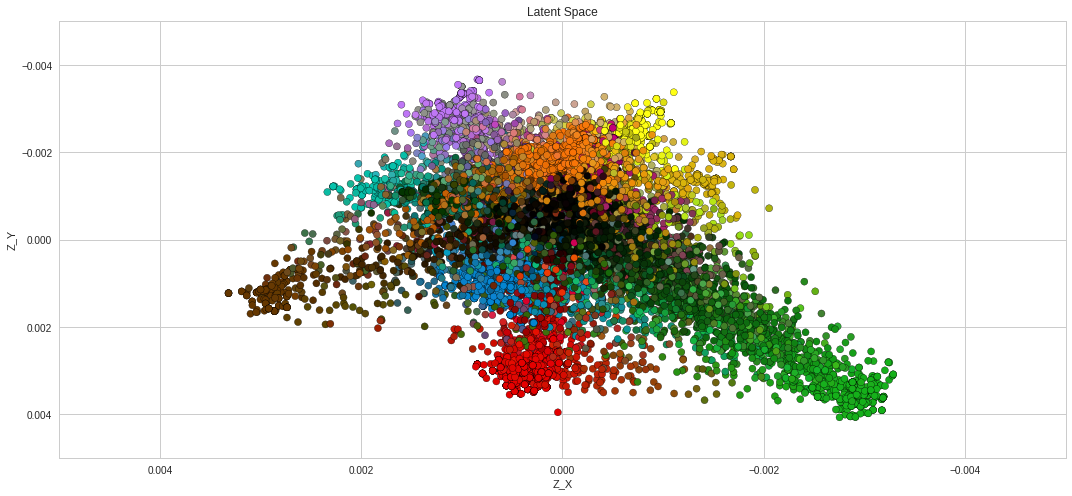

In [113]:
z_train = c_encoder.predict([data_['yc'], to_categorical(data_['yd']), to_categorical(data_['yt'])])
c_encoding = np.asarray(z_train)
print(c_encoding.shape)

x = c_encoding[:,0]
y = c_encoding[:,1]

x_max = max(abs(x))*1.1
y_max = max(abs(y))*1.1
yc_colz = [tuple(x) for x in data_['yc_colors'].tolist()]
fig = plt.figure(figsize=(15,7))
plt.scatter(x=x, y=y, c=yc_colz, s=50, edgecolors='black')
plt.xlim([0.005, -0.005])
plt.ylim([0.005, -0.005])
# plt.autoscale()
plt.title('Latent Space')
plt.xlabel('Z_X')
plt.ylabel('Z_Y')
plt.tight_layout()
plt.savefig('VAE_TD_Latent_Space.png', format='png', dpi=1000)

# VAE conditioned on minute, time and day

In [114]:
# print(to_categorical(data_['y_train_m'], num_classes=data_['minute']).shape)
print(data_['y_train_m'])
print(data_['y_train_t'])

[ 4.  5.  9. ...,  6.  7.  8.]
[15 15 15 ...,  9  9  9]


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
Input (InputLayer)               (None, 15)            0                                            
____________________________________________________________________________________________________
Day (InputLayer)                 (None, 7)             0                                            
____________________________________________________________________________________________________
Hour (InputLayer)                (None, 24)            0                                            
____________________________________________________________________________________________________
Minute (InputLayer)              (None, 12)            0                                            
___________________________________________________________________________________________

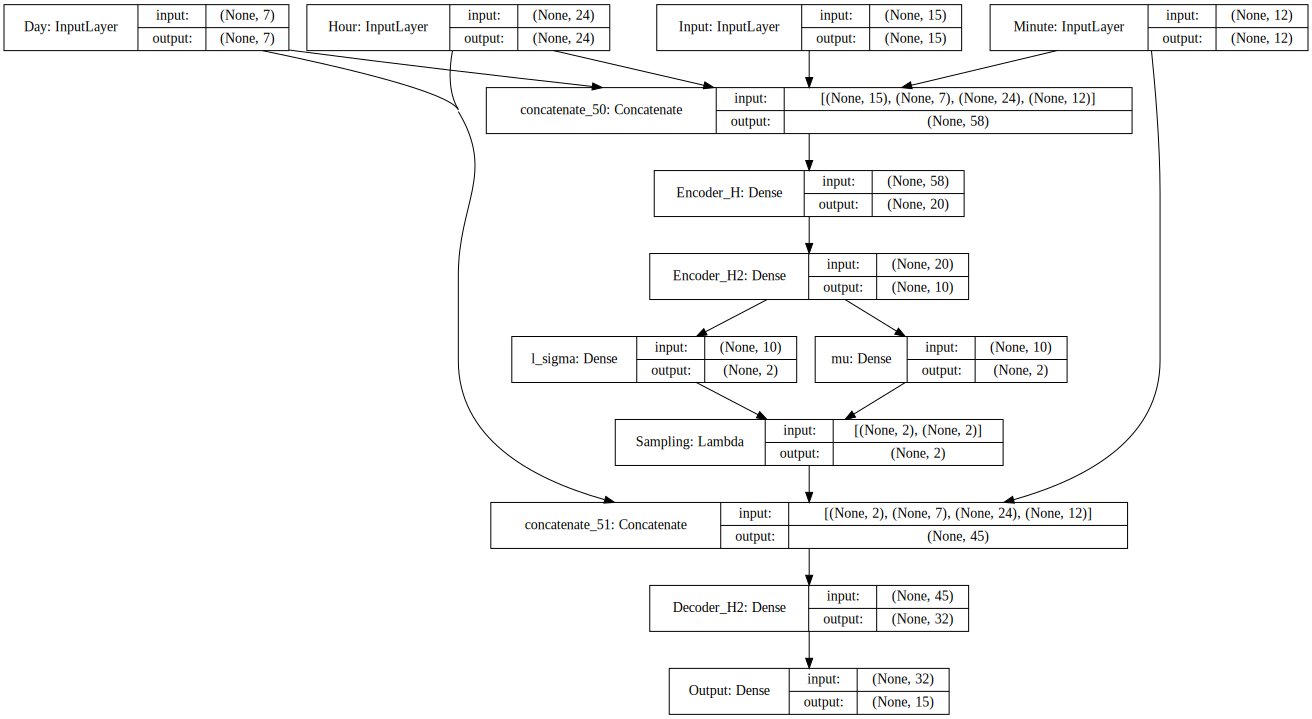

In [115]:
original_dim=15
batch_size = 100
latent_dim = 2
intermediate_dim = 10
activ='relu'
optim=Adam(lr=0.0005)
epsilon_std=1.
time_dim=24
day_dim=7
minute_dim = 12

    
def sample_z(args):
    mu, l_sigma = args
    eps = K.random_normal(shape=(m, n_z), mean=0., stddev=1.)
    return mu + K.exp(l_sigma / 2) * eps

m = batch_size # batch size
n_z = latent_dim # latent space size
encoder_dim1 = intermediate_dim # dim of encoder hidden layer
decoder_dim = intermediate_dim # dim of decoder hidden layer
decoder_out_dim = original_dim # dim of decoder output layer

n_x = original_dim
# n_y = y_train.shape[1]


n_epoch = 100
n_d = day_dim
n_t = time_dim
n_m = minute_dim
n_epoch = 100

X = Input(shape=(n_x,), name='Input')
day = Input(shape=(n_d,), name='Day')
time = Input(shape=(n_t,), name='Hour')
minute = Input(shape=(n_m,), name='Minute')

inputs = Concatenate()([X, day, time, minute])

encoder_h = Dense(encoder_dim1*2, activation=activ,  name='Encoder_H')(inputs)
encoder_h = Dense(encoder_dim1, activation=activ,  name='Encoder_H2')(encoder_h)
mu = Dense(n_z, activation='linear', name='mu')(encoder_h)
l_sigma = Dense(n_z, activation='linear', name='l_sigma')(encoder_h)

# Sampling latent space
z = Lambda(sample_z, output_shape = (n_z, ), name='Sampling')([mu, l_sigma])
zc = Concatenate()([z, day, time, minute])

#decoder_hidden = Dense(decoder_dim, activation=activ, name='Decoder_H')
#decoder_hidden2 = Dense(decoder_dim2, activation=activ, name='Decoder_H2')

#decoder_out = Dense(decoder_out_dim, activation='linear', name='Output')
decoder_hidden = Dense(decoder_dim, activation=activ, name='Decoder_H')
decoder_hidden2 = Dense(32, activation=activ, name='Decoder_H2')
decoder_out = Dense(decoder_out_dim, activation='linear', name='Output')
h_p = decoder_hidden2(zc)
# h_p = decoder_hidden(h_p)
outputs = decoder_out(h_p)


def vae_loss(y_true, y_pred):
    recon = original_dim * metrics.mse(y_pred, y_true)
    kl = 0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=1)
    return recon + kl

def KL_loss(y_true, y_pred):
    return(0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=1))

def recon_loss(y_true, y_pred):
    return original_dim * metrics.mse(y_pred, y_true)

# build a model to project inputs on the latent space


d_in = Input(shape=(n_z+n_t+n_d+n_m,))

decoder_hidden = Dense(decoder_dim, activation=activ, name='Decoder_H')
decoder_out = Dense(decoder_out_dim, activation='linear', name='Output')
h_p = decoder_hidden(d_in)
d_out = decoder_out(h_p)

ctd_vae = Model([X, day, time, minute], outputs)
ctd_encoder = Model([X, day, time, minute], mu)
ctd_generator = Model(d_in, d_out)


ctd_vae.compile(optimizer='rmsprop',
        loss=vae_loss,
        metrics = [KL_loss, recon_loss])

print(ctd_vae.summary())
plot_model(ctd_vae, to_file='c_vae.png', show_shapes=True, show_layer_names=True)
SVG(model_to_dot(ctd_vae, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [116]:
# compile and fit
c_vae_hist = c_vae.fit([data_['y_train_c'], to_categorical(data_['y_train_d']), to_categorical(data_['y_train_t']), to_categorical(data_['y_train_m'])], 
                            data_['y_train_c'], 
                            verbose = 0, 
                            batch_size=batch_size, 
                            epochs=100,
                            validation_data = (
                                [data_['y_test_c'], to_categorical(data_['y_test_d']),to_categorical(data_['y_test_t']),to_categorical(data_['y_test_m'])], 
                                data_['y_test_c']),
                            callbacks = [EarlyStopping(patience = 5)])


print(min(c_vae_hist.history['val_loss']))
fig = plt.figure(figsize=(15,7))
x = np.arange(len(c_vae_hist.history['val_loss']))
linewidth=2
linetype = '-'
plt.plot(x, c_vae_hist.history['val_loss'], linetype, linewidth=linewidth, label='Validation Loss')
plt.plot(x, c_vae_hist.history['val_KL_loss'], linetype, linewidth=linewidth, label = 'Validation KL Loss')
plt.plot(x, c_vae_hist.history['val_recon_loss'], linetype, linewidth=linewidth, label='Validation Reconstruction Loss')
plt.plot(x, c_vae_hist.history['loss'], linetype, linewidth=linewidth, label='Training Loss')
plt.plot(x, c_vae_hist.history['KL_loss'], linetype, linewidth=linewidth, label='Training KL Loss')
plt.plot(x, c_vae_hist.history['recon_loss'], linetype, linewidth=linewidth, label='Training Reconstruction Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('CVAE_TDM Losses.png', format='png', dpi=1000)

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 3 arrays but instead got the following list of 4 arrays: [array([[ 0.03666667,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.01666667],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.21666667],...

(18200, 2)


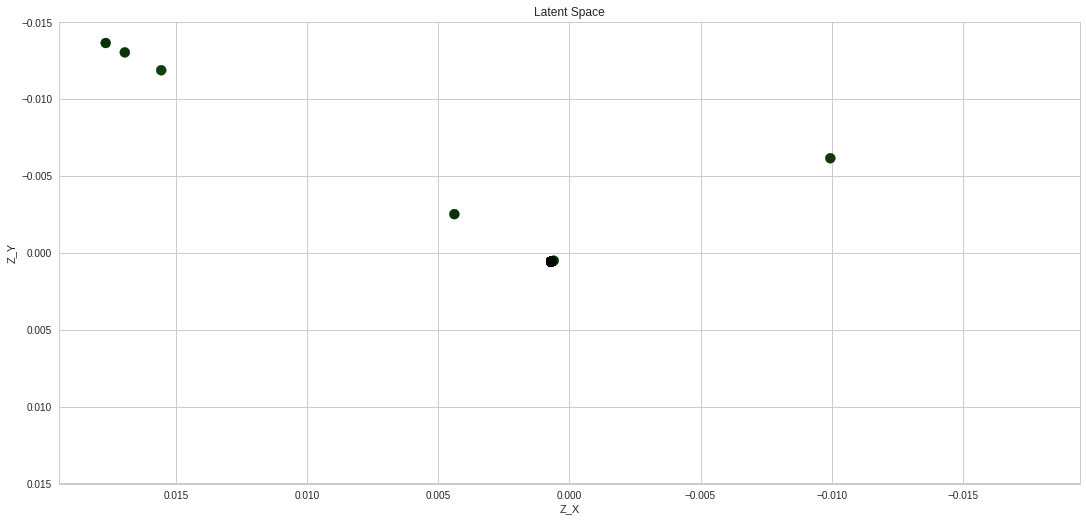

In [90]:
z_train = c_encoder.predict([data_['yc'], to_categorical(data_['yd']), to_categorical(data_['yt']), to_categorical(data_['ym'])])
c_encoding = np.asarray(z_train)
print(c_encoding.shape)

x = c_encoding[:,0]
y = c_encoding[:,1]

x_max = max(abs(x))*1.1
y_max = max(abs(y))*1.1
yc_colz = [tuple(x) for x in data_['yc_colors'].tolist()]
fig = plt.figure(figsize=(15,7))
plt.scatter(x=x, y=y, c=yc_colz, s=50, edgecolors='black')
plt.xlim([x_max, -x_max])
plt.ylim([y_max, -y_max])
# plt.autoscale()
plt.title('Latent Space')
plt.xlabel('Z_X')
plt.ylabel('Z_Y')
plt.tight_layout()
plt.savefig('C_VAE_TDM_Space.png', format='png', dpi=1200)

# VAE conditioned on previous activity

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
Previous_X (InputLayer)          (None, 5, 15)         0                                            
____________________________________________________________________________________________________
LSTM_Encoder (LSTM)              (None, 32)            6144        Previous_X[0][0]                 
____________________________________________________________________________________________________
activation_23 (Activation)       (None, 32)            0           LSTM_Encoder[0][0]               
____________________________________________________________________________________________________
X (InputLayer)                   (None, 15)            0                                            
___________________________________________________________________________________________

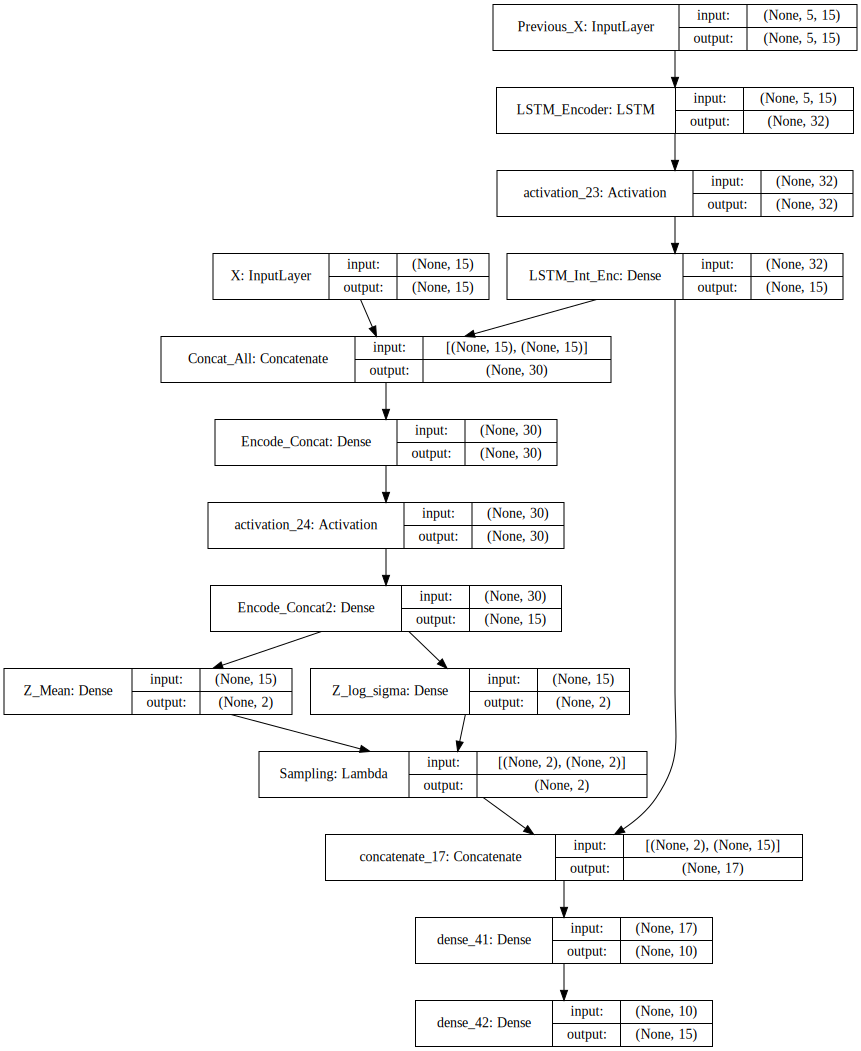

In [53]:
original_dim=15
timesteps=5
batch_size = 100
latent_dim = 2
lstm_dim = 32
intermediate_dim = 15
activ='relu'
optim=Adam(lr=0.0005)
epsilon_std=1
time_dim=24
day_dim=7
minute_dim=12
    

input_dim = original_dim

n_epoch = 100
n_d = day_dim
n_t = time_dim
n_m = minute_dim
n_epoch = 100

previous_X = Input(shape=(timesteps, original_dim), name='Previous_X')
day = Input(shape=(n_d,), name='Day')
time = Input(shape=(n_t,), name='Hour')
minute = Input(shape=(n_m,), name='Minute')
X = Input(shape=(original_dim,), name='X')
time_total= Concatenate(name='Concat_Time')([day, time])

# LSTM encoding
h = LSTM(lstm_dim, activation='linear', name='LSTM_Encoder')(previous_X)
# h = BatchNormalization(name='BatchNorm_LSTM')(h)
h = Activation('elu')(h)
h = Dense(intermediate_dim, activation=activ, name='LSTM_Int_Enc')(h)

input_concat = Concatenate(name='Concat_All')([X, h])
# input_concat = Concatenate(name='Concat_All')([X, h, time_total])
input_concat = Dense(intermediate_dim*2, activation='linear', name='Encode_Concat')(input_concat)
# input_concat = BatchNormalization(name='BatchNorm_Concat')(input_concat)
input_concat = Activation('elu')(input_concat)
input_concat = Dense(intermediate_dim, activation=activ, name='Encode_Concat2')(input_concat)
# input_concat = Dropout(0.2, name='Dropout_Concat')(input_concat)
# VAE Z layer
z_mean = Dense(latent_dim, activation='linear', name='Z_Mean')(input_concat)
z_log_sigma = Dense(latent_dim, activation='linear', name='Z_log_sigma')(input_concat)

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim),
                              mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_sigma) * epsilon_std

z = Lambda(sampling, output_shape=(latent_dim,), name='Sampling')([z_mean, z_log_sigma])

# zc = Concatenate()([z, h, time_total])
zc = Concatenate()([z, h])

# decoder_h = Dense(5, activation=activ)
decoder_h2 = Dense(10, activation=activ)
decoder_mean = Dense(input_dim, activation='linear')

# h_decoded = decoder_h(zc)
h_decoded2 = decoder_h2(zc)
x_decoded_mean = decoder_mean(h_decoded2)

decoder_input = Input(shape=(latent_dim+intermediate_dim,))
# decoder_input = Input(shape=(latent_dim+intermediate_dim+n_d+n_t,))
# _h_decoded = decoder_h(decoder_input)
_h_decoded = decoder_h2(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)

def vae_loss(x, x_decoded_mean):
    xent_loss = original_dim * objectives.mse(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma))
    loss = xent_loss + kl_loss
    return loss

def recon_loss(x, x_decoded_mean):
    xent_loss = original_dim * objectives.mse(x, x_decoded_mean)
    return xent_loss

def KL_loss(x, x_decoded_mean):
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma))
    return kl_loss

generator = Model(decoder_input, _x_decoded_mean)

vae_prev = Model([X, previous_X], x_decoded_mean)
encoder_prev = Model([X, previous_X], z_mean)

# vae_prev = Model([X, previous_X, day, time], x_decoded_mean)
# encoder_prev = Model([X, previous_X, day, time], z_mean)

vae_prev.compile(optimizer='rmsprop',
            loss=vae_loss,
            metrics = [KL_loss, recon_loss])
print(vae_prev.summary())
plot_model(vae_prev, to_file='cvae_prev.png', show_shapes=True, show_layer_names=True)
SVG(model_to_dot(vae_prev, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [54]:
x_d = np.asarray([to_categorical(x, num_classes=data_['days']) for x in data_['Xd']])
x_t = np.asarray([to_categorical(x, num_classes=data_['time']) for x in data_['Xt']])
x_m = np.asarray([to_categorical(x, num_classes=data_['minute']) for x in data_['Xm']])

x_train_d = np.asarray([to_categorical(x, num_classes=data_['days']) for x in data_['x_train_d']])
x_train_t = np.asarray([to_categorical(x, num_classes=data_['time']) for x in data_['x_train_t']])
x_train_m = np.asarray([to_categorical(x, num_classes=data_['minute']) for x in data_['x_train_m']])

x_test_d = np.asarray([to_categorical(x, num_classes=data_['days']) for x in data_['x_test_d']])
x_test_t = np.asarray([to_categorical(x, num_classes=data_['time']) for x in data_['x_test_t']])
x_test_m = np.asarray([to_categorical(x, num_classes=data_['minute']) for x in data_['x_test_m']])


0.245245763618


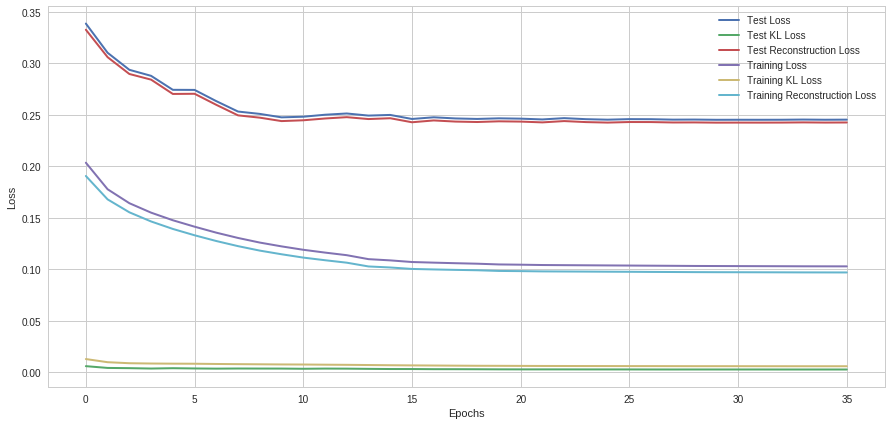

In [55]:
c_vae_hist = vae_prev.fit([data_['x_train_c'][:,5,:], data_['x_train_c'][:,:5,:]], 
                            data_['x_train_c'][:,5,:], 
                            verbose = 0, 
                            batch_size=batch_size, 
                            epochs=1000,
                            validation_data = (
                                [data_['x_test_c'][:,5,:], data_['x_test_c'][:,:5,:]],
                                data_['x_test_c'][:,5,:]),
                            callbacks = [EarlyStopping(patience = 5), ReduceLROnPlateau(factor=0.5, patience=2)])


print(min(c_vae_hist.history['val_loss']))
fig = plt.figure(figsize=(15,7))
x = np.arange(len(c_vae_hist.history['val_loss'])-1)
linewidth=2
linetype = '-'
plt.plot(x, c_vae_hist.history['val_loss'][1:], linetype, linewidth=linewidth, label='Test Loss')
plt.plot(x, c_vae_hist.history['val_KL_loss'][1:], linetype, linewidth=linewidth, label = 'Test KL Loss')
plt.plot(x, c_vae_hist.history['val_recon_loss'][1:], linetype, linewidth=linewidth, label='Test Reconstruction Loss')
plt.plot(x, c_vae_hist.history['loss'][1:], linetype, linewidth=linewidth, label='Training Loss')
plt.plot(x, c_vae_hist.history['KL_loss'][1:], linetype, linewidth=linewidth, label='Training KL Loss')
plt.plot(x, c_vae_hist.history['recon_loss'][1:], linetype, linewidth=linewidth, label='Training Reconstruction Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('C_VAE_Losses_prev_X.png', format='png', dpi=1000)

# c_vae_hist = vae_prev.fit([data_['x_train_c'][:,5,:], data_['x_train_c'][:,:5,:],x_train_d[:,5,:], x_train_t[:,5,:], x_train_m[:,5,:]], 
#                             data_['x_train_c'][:,5,:], 
#                             verbose = 2, 
#                             batch_size=batch_size, 
#                             epochs=1000,
#                             validation_data = (
#                                 [data_['x_test_c'][:,5,:], data_['x_test_c'][:,:5,:], x_test_d[:,5,:], x_test_t[:,5,:], x_test_m[:,5,:]],
#                                 data_['x_test_c'][:,5,:]),
#                             callbacks = [EarlyStopping(patience = 5), ReduceLROnPlateau(factor=0.5, patience=2)])

# c_vae_hist = vae_prev.fit([data_['x_train_c'][:,5,:], data_['x_train_c'][:,:5,:],x_train_d[:,5,:], x_train_t[:,5,:]], 
#                             data_['x_train_c'][:,5,:], 
#                             verbose = 0, 
#                             batch_size=batch_size, 
#                             epochs=1000,
#                             validation_data = (
#                                 [data_['x_test_c'][:,5,:], data_['x_test_c'][:,:5,:], x_test_d[:,5,:], x_test_t[:,5,:]],
#                                 data_['x_test_c'][:,5,:]),
#                             callbacks = [EarlyStopping(patience = 5), ReduceLROnPlateau(factor=0.5, patience=2)])


# print(min(c_vae_hist.history['val_loss']))
# fig = plt.figure(figsize=(15,7))
# x = np.arange(len(c_vae_hist.history['val_loss'])-1)
# linewidth=2
# linetype = '-'
# plt.plot(x, c_vae_hist.history['val_loss'][1:], linetype, linewidth=linewidth, label='Test Loss')
# plt.plot(x, c_vae_hist.history['val_KL_loss'][1:], linetype, linewidth=linewidth, label = 'Test KL Loss')
# plt.plot(x, c_vae_hist.history['val_recon_loss'][1:], linetype, linewidth=linewidth, label='Test Reconstruction Loss')
# plt.plot(x, c_vae_hist.history['loss'][1:], linetype, linewidth=linewidth, label='Training Loss')
# plt.plot(x, c_vae_hist.history['KL_loss'][1:], linetype, linewidth=linewidth, label='Training KL Loss')
# plt.plot(x, c_vae_hist.history['recon_loss'][1:], linetype, linewidth=linewidth, label='Training Reconstruction Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# # plt.savefig('C_VAE_Losses_prev_X_TD.png', format='png', dpi=1000)

(18200, 2)


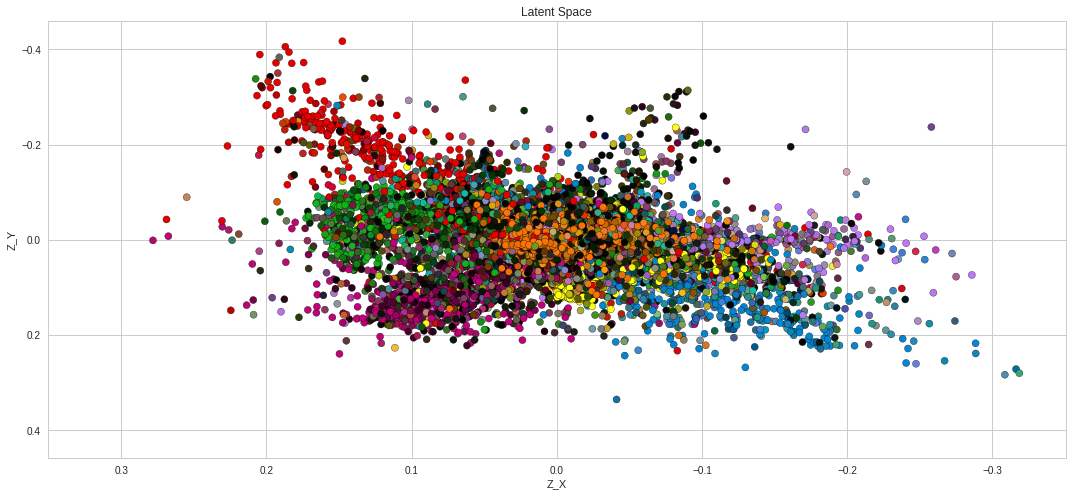

In [57]:
z_train = encoder_prev.predict([data_['Xc'][:,5,:], data_['Xc'][:,:5,:], x_d[:,5,:], x_t[:,5,:]])
# z_train = encoder_prev.predict([data_['Xc'][:,5,:], data_['Xc'][:,:5,:]])
c_encoding = np.asarray(z_train)
print(c_encoding.shape)

x = c_encoding[:,0]
y = c_encoding[:,1]

x_max = max(abs(x))*1.1
y_max = max(abs(y))*1.1
yc_colz = [tuple(x) for x in data_['yc_colors'].tolist()]
fig = plt.figure(figsize=(15,7))
plt.scatter(x=x, y=y, c=yc_colz, s=50, edgecolors='black')
plt.xlim([x_max, -x_max])
plt.ylim([y_max, -y_max])
# plt.autoscale()
plt.title('Latent Space')
plt.xlabel('Z_X')
plt.ylabel('Z_Y')
plt.tight_layout()
plt.savefig('C_VAE_Prev_TD_Latent_Space.png', format='png', dpi=1000)

# LSTM VAE

/home/asturkmani/Thesis-Old/utils.py:253: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



(41183, 1, 1) (41183,) (41183, 1, 1) (41183,)
1
(41182, 2, 1) (41182,) (41182, 2, 1) (41182,)
2
(41181, 3, 1) (41181,) (41181, 3, 1) (41181,)
3
(41180, 4, 1) (41180,) (41180, 4, 1) (41180,)
4
(41179, 5, 1) (41179,) (41179, 5, 1) (41179,)
5
(41178, 6, 1) (41178,) (41178, 6, 1) (41178,)
6
(41177, 7, 1) (41177,) (41177, 7, 1) (41177,)
7
(41176, 8, 1) (41176,) (41176, 8, 1) (41176,)
8
(41175, 9, 1) (41175,) (41175, 9, 1) (41175,)
9


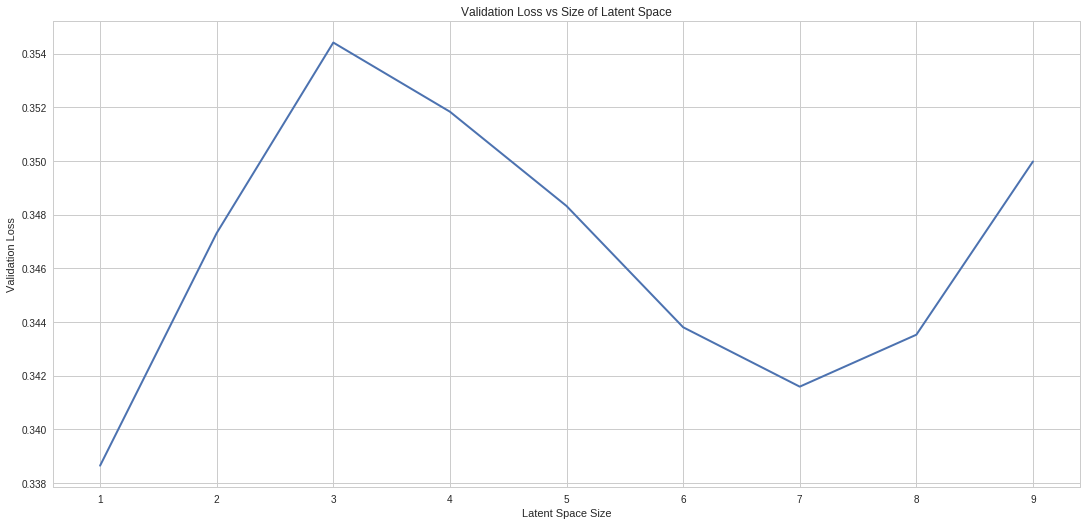

In [15]:
losses = list()
original_dim = data_['x_train_c'].shape[-1] # 13
timesteps = data_['x_train_c'].shape[1] # 3
# time_dim = data_['time']
# day_dim = data_['days']

batch_size = 100
latent_dim = 2
lstm_dim = 32
intermediate_dim = 0

for timesteps in range(1,10):
    data_ = make_clean_data(timesteps, batch_size,multiplier=1)
    print(timesteps)
    lstm_vae, lstm_encoder, lstm_generator= build_lstm_c_vae(original_dim=original_dim,
                                       timesteps=timesteps,
                                       batch_size=batch_size,
                                       latent_dim=2,
                                       lstm_dim=lstm_dim,
                                       intermediate_dim=0,
                                       activ='relu',
                                       optim=RMSprop(),
                                       epsilon_std=1.,
                                       time_dim=0,
                                       day_dim=0)

    lstm_vae_hist = lstm_vae.fit(data_['x_train_c'], 
                   data_['x_train_c'],
                   verbose = 0,
                   batch_size=batch_size,
                   epochs=20,
                   validation_data = (
                       data_['x_test_c'],
                       data_['x_test_c']),
                   callbacks = [
                       EarlyStopping(patience = 3, min_delta=0.0001),
                       ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=1, min_lr=0.000001, verbose=0)]
                  )
    losses.append(min(lstm_vae_hist.history['val_loss']))
    
    
x = np.arange(len(losses))+1
fig = plt.figure(figsize=(15,7))
linewidth=2
linetype = '-'
plt.plot(x, losses, linetype, linewidth=linewidth)
# plt.autoscale()
plt.tight_layout()
plt.title('Validation Loss vs Size of Latent Space')
plt.xlabel('Latent Space Size')
plt.ylabel('Validation Loss')
plt.savefig('LSTM_VAE_window_loss.svg', format='svg', dpi=1200)

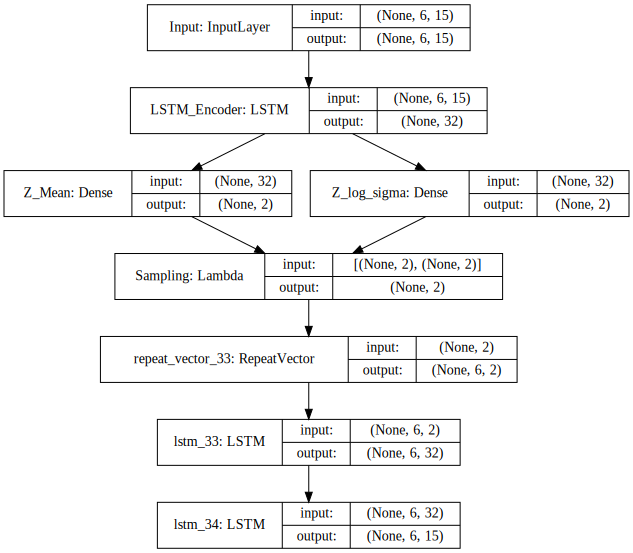

In [10]:
original_dim = data_['x_train_c'].shape[-1] # 13
timesteps = data_['x_train_c'].shape[1] # 3
# time_dim = data_['time']
# day_dim = data_['days']

batch_size = 100
latent_dim = 2
lstm_dim = 32
intermediate_dim = 0
        
lstm_vae, lstm_encoder, lstm_generator= build_lstm_c_vae(original_dim,
                                       timesteps,
                                       batch_size,
                                       latent_dim,
                                       lstm_dim,
                                       intermediate_dim,
                                       activ='relu',
                                       optim=RMSprop(),
                                       epsilon_std=1.,
                                       time_dim=0,
                                       day_dim=0)

# print(lstm_vae.summary())
SVG(model_to_dot(lstm_vae, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

0.35607913716


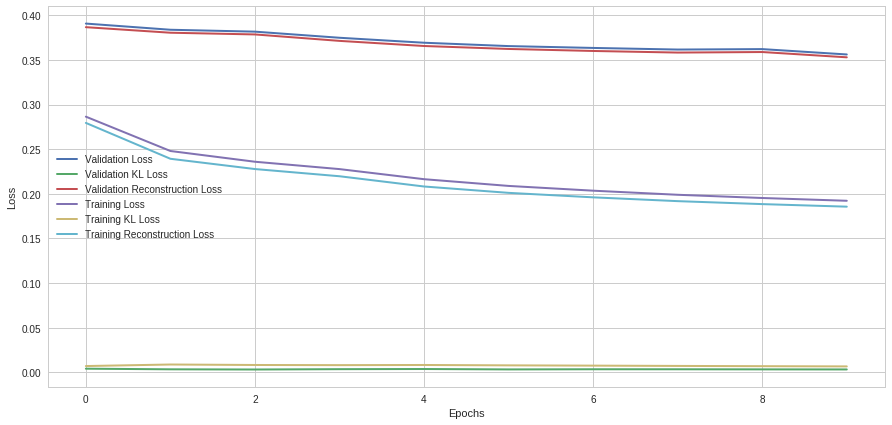

In [11]:
lstm_vae_hist = lstm_vae.fit(data_['x_train_c'], 
                   data_['x_train_c'],
                   verbose = 0,
                   batch_size=batch_size,
                   epochs=10,
                   validation_data = (
                       data_['x_test_c'],
                       data_['x_test_c']),
                   callbacks = [
                       EarlyStopping(patience = 5, min_delta=0.0001),
                       ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=2, min_lr=0.000001, verbose=0)]
                  )

print(min(lstm_vae_hist.history['val_loss']))
fig = plt.figure(figsize=(15,7))
x = np.arange(len(lstm_vae_hist.history['val_loss']))
linewidth=2
linetype = '-'
plt.plot(x, lstm_vae_hist.history['val_loss'], linetype, linewidth=linewidth, label='Validation Loss')
plt.plot(x, lstm_vae_hist.history['val_KL_loss'], linetype, linewidth=linewidth, label = 'Validation KL Loss')
plt.plot(x, lstm_vae_hist.history['val_recon_loss'], linetype, linewidth=linewidth, label='Validation Reconstruction Loss')
plt.plot(x, lstm_vae_hist.history['loss'], linetype, linewidth=linewidth, label='Training Loss')
plt.plot(x, lstm_vae_hist.history['KL_loss'], linetype, linewidth=linewidth, label='Training KL Loss')
plt.plot(x, lstm_vae_hist.history['recon_loss'], linetype, linewidth=linewidth, label='Training Reconstruction Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('LSTM_VAE Losses.svg', format='svg', dpi=1200)

# Show color of average activity over time period

(18200, 2)


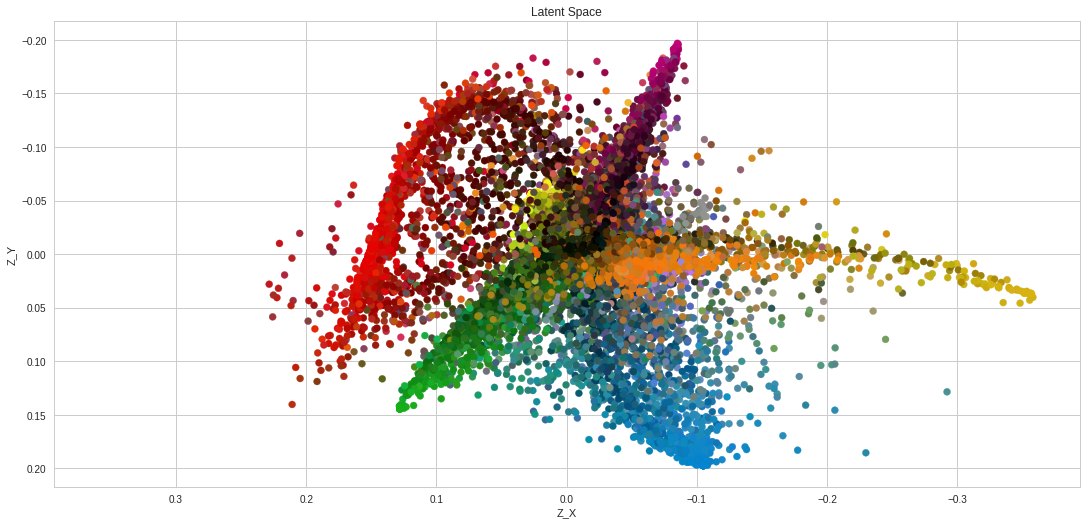

In [13]:
z_train = lstm_encoder.predict(data_['Xc'])
encodings= np.asarray(z_train)
encodings = encodings.reshape(data_['Xc'].shape[0], latent_dim)
xavg = data_['Xc'].mean(axis=1)
avg_colors = np.einsum('ij,jk->ik', xavg, data_['data_colors'])
avg_colors = [tuple(x) for x in avg_colors.tolist()]
print(encodings.shape)

x = encodings[:,0]
y = encodings[:,1]

x_max = max(abs(x))*1.1
y_max = max(abs(y))*1.1

fig = plt.figure(figsize=(15,7))
plt.scatter(x=x, y=y, c=avg_colors)
plt.xlim([x_max, -x_max])
plt.ylim([y_max, -y_max])
# plt.autoscale()
plt.tight_layout()
plt.title('Latent Space')
plt.xlabel('Z_X')
plt.ylabel('Z_Y')
plt.savefig('Seq2Seq_VAE_Latent_Space.svg', format='svg', dpi=1200)

# LSTM VAE with Time & Day

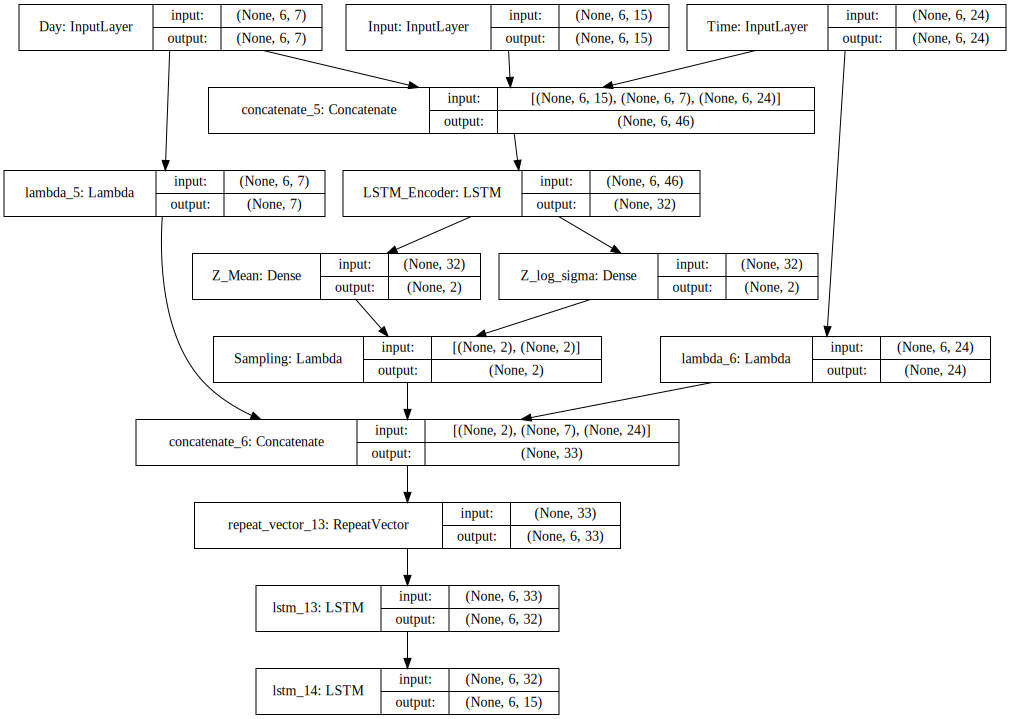

In [32]:
original_dim = data_['x_train_c'].shape[-1] # 13
timesteps = data_['x_train_c'].shape[1] # 3
# time_dim = data_['time']
# day_dim = data_['days']

batch_size = 50
latent_dim = 2
lstm_dim = 32
intermediate_dim = 0
        
clstm_vae, clstm_encoder, clstm_generator= build_lstm_c_vae(original_dim,
                                       timesteps,
                                       batch_size,
                                       latent_dim,
                                       lstm_dim,
                                       intermediate_dim,
                                       activ='relu',
                                       optim=Adam(lr=0.005),
                                       epsilon_std=1.,
                                       time_dim=24,
                                       day_dim=7)

# print(lstm_vae.summary())
SVG(model_to_dot(clstm_vae, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [33]:
x_d = np.asarray([to_categorical(x, num_classes=data_['days']) for x in data_['Xd']])
x_t = np.asarray([to_categorical(x, num_classes=data_['time']) for x in data_['Xt']])

x_train_d = np.asarray([to_categorical(x, num_classes=data_['days']) for x in data_['x_train_d']])
x_train_t = np.asarray([to_categorical(x, num_classes=data_['time']) for x in data_['x_train_t']])

x_test_d = np.asarray([to_categorical(x, num_classes=data_['days']) for x in data_['x_test_d']])
x_test_t = np.asarray([to_categorical(x, num_classes=data_['time']) for x in data_['x_test_t']])

# compile and fit
clstm_vae_hist = clstm_vae.fit(
    [data_['x_train_c'], x_train_d, x_train_t], 
    data_['x_train_c'], 
    verbose = 0, 
    batch_size=batch_size, 
    epochs=100,
    validation_data = ([data_['x_test_c'], x_test_d,x_test_t], 
                        data_['x_test_c']),
    callbacks = [EarlyStopping(patience = 5, min_delta=0.0001),ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=2, min_lr=0.000001, verbose=0)])

(18200, 2)


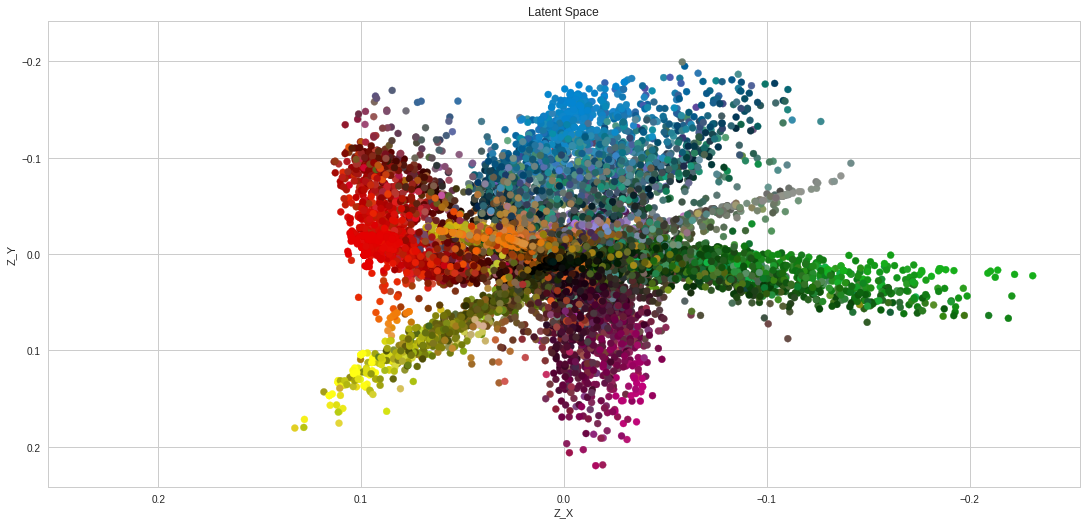

In [35]:
z_train = clstm_encoder.predict([data_['Xc'], x_d, x_t])
encodings= np.asarray(z_train)
encodings = encodings.reshape(data_['Xc'].shape[0], latent_dim)
xavg = data_['Xc'].mean(axis=1)
avg_colors = np.einsum('ij,jk->ik', xavg, data_['data_colors'])
avg_colors = [tuple(x) for x in avg_colors.tolist()]
print(encodings.shape)

x = encodings[:,0]
y = encodings[:,1]

x_max = max(abs(x))*1.1
y_max = max(abs(y))*1.1

fig = plt.figure(figsize=(15,7))
plt.scatter(x=x, y=y, c=avg_colors)
plt.xlim([x_max, -x_max])
plt.ylim([y_max, -y_max])
# plt.autoscale()
plt.tight_layout()
plt.title('Latent Space')
plt.xlabel('Z_X')
plt.ylabel('Z_Y')
plt.savefig('Seq2Seq_CVAE_Latent_Space.svg', format='svg', dpi=1200)

# Conv1D / LSTM for Time Series Prediction

Here we examine first using a conv1d/lstm to make time-series regression on the next 5-minute block and visualize hidden states in the latent space

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 6, 15)             0         
_________________________________________________________________
Conv1 (Conv1D)               (None, 4, 64)             2944      
_________________________________________________________________
Flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
Dense_Out2 (Dense)           (None, 15)                3855      
Total params: 6,799
Trainable params: 6,799
Non-trainable params: 0
_________________________________________________________________
None


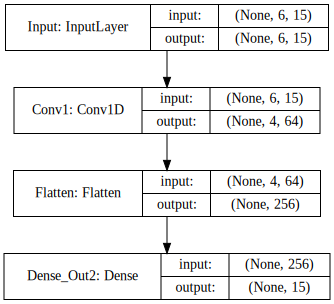

In [13]:
window_size=6
filter_length=3
original_dim = data_['x_train_c'].shape[-1]
nb_input_series=original_dim
nb_outputs=original_dim
nb_filter=64

inputs = Input(shape=(window_size, original_dim), name='Input')
conv1 = Conv1D(name='Conv1', 
               filters=nb_filter, 
               kernel_size=filter_length, 
               activation='elu', 
               input_shape=(window_size, nb_input_series)
              )(inputs)

flat1 = Flatten(name='Flatten')(conv1)
output = Dense(nb_outputs, activation='relu',name='Dense_Out2')(flat1)     # For binary classification, change the activation to 'sigmoid'
 
conv_encoder = Model(inputs,flat1)
conv_model = Model(inputs,output)
conv_model.compile(loss='mse', optimizer='adam', metrics=['mae'])
print(conv_model.summary())
# To perform (binary) classification instead:
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
SVG(model_to_dot(conv_model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [8]:
losses= list()
for window_size in range(1,12):
    filter_length=3
    if filter_length > window_size:
        filter_length = window_size
    timesteps = window_size
    data_ = make_clean_data(window_size, batch_size,multiplier=1)
    print(timesteps)

    inputs = Input(shape=(window_size, original_dim), name='Input')
    conv1 = Conv1D(name='Conv1', 
                   filters=nb_filter, 
                   kernel_size=filter_length, 
                   activation='elu', 
                   input_shape=(window_size, nb_input_series)
                  )(inputs)

    flat1 = Flatten(name='Flatten')(conv1)
    output = Dense(nb_outputs, activation='elu',name='Dense_Out2')(flat1)     # For binary classification, change the activation to 'sigmoid'

    conv_encoder = Model(inputs,flat1)
    conv_model = Model(inputs,output)
    conv_model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    
    
    early_stop = EarlyStopping(monitor='val_loss', patience=5)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=2, min_lr=0.000001, verbose=0)
    conv_model_data = conv_model.fit(
        data_['x_train_c'], 
        data_['y_train_c'], 
        verbose=2, 
        epochs=1000, 
        batch_size=128, 
        validation_data=(data_['x_test_c'], data_['y_test_c']), 
        callbacks=[reduce_lr,early_stop])
    losses.append(min(conv_model_data.history['val_loss']))

x = np.arange(len(losses))+1
fig = plt.figure(figsize=(15,7))
linewidth=2
linetype = '-'
plt.plot(x, losses, linetype, linewidth=linewidth)
# plt.autoscale()
plt.tight_layout()
plt.title('Validation Loss vs Window Size')
plt.xlabel('Window Size')
plt.ylabel('Validation Loss')
plt.savefig('Conv1D_window_loss.svg', format='svg', dpi=1200)

/home/asturkmani/Thesis-Old/utils.py:253: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



(41183, 1, 1) (41183,) (41183, 1, 1) (41183,)
1
Train on 14600 samples, validate on 3600 samples
Epoch 1/1000
0s - loss: 0.0172 - mean_absolute_error: 0.0637 - val_loss: 0.0159 - val_mean_absolute_error: 0.0599
Epoch 2/1000
0s - loss: 0.0123 - mean_absolute_error: 0.0432 - val_loss: 0.0135 - val_mean_absolute_error: 0.0493
Epoch 3/1000
0s - loss: 0.0122 - mean_absolute_error: 0.0418 - val_loss: 0.0136 - val_mean_absolute_error: 0.0492
Epoch 4/1000
0s - loss: 0.0122 - mean_absolute_error: 0.0417 - val_loss: 0.0134 - val_mean_absolute_error: 0.0493
Epoch 5/1000
0s - loss: 0.0122 - mean_absolute_error: 0.0416 - val_loss: 0.0133 - val_mean_absolute_error: 0.0485
Epoch 6/1000
0s - loss: 0.0122 - mean_absolute_error: 0.0417 - val_loss: 0.0133 - val_mean_absolute_error: 0.0489
Epoch 7/1000
0s - loss: 0.0122 - mean_absolute_error: 0.0415 - val_loss: 0.0134 - val_mean_absolute_error: 0.0495
Epoch 8/1000
0s - loss: 0.0122 - mean_absolute_error: 0.0417 - val_loss: 0.0138 - val_mean_absolute_error

KeyboardInterrupt: 

In [14]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=2, min_lr=0.000001, verbose=0)
conv_model_data = conv_model.fit(
    data_['x_train_c'], 
    data_['y_train_c'], 
    verbose=2, 
    epochs=1000, 
    batch_size=128, 
    validation_data=(data_['x_test_c'], data_['y_test_c']), 
    callbacks=[reduce_lr,early_stop])

Train on 14600 samples, validate on 3600 samples
Epoch 1/1000
0s - loss: 0.0191 - mean_absolute_error: 0.0430 - val_loss: 0.0272 - val_mean_absolute_error: 0.0545
Epoch 2/1000
0s - loss: 0.0159 - mean_absolute_error: 0.0391 - val_loss: 0.0152 - val_mean_absolute_error: 0.0434
Epoch 3/1000
0s - loss: 0.0155 - mean_absolute_error: 0.0383 - val_loss: 0.0143 - val_mean_absolute_error: 0.0407
Epoch 4/1000
0s - loss: 0.0153 - mean_absolute_error: 0.0382 - val_loss: 0.0134 - val_mean_absolute_error: 0.0405
Epoch 5/1000
0s - loss: 0.0137 - mean_absolute_error: 0.0379 - val_loss: 0.0136 - val_mean_absolute_error: 0.0431
Epoch 6/1000
0s - loss: 0.0125 - mean_absolute_error: 0.0369 - val_loss: 0.0132 - val_mean_absolute_error: 0.0408
Epoch 7/1000
0s - loss: 0.0125 - mean_absolute_error: 0.0367 - val_loss: 0.0131 - val_mean_absolute_error: 0.0417
Epoch 8/1000
0s - loss: 0.0125 - mean_absolute_error: 0.0367 - val_loss: 0.0130 - val_mean_absolute_error: 0.0402
Epoch 9/1000
0s - loss: 0.0124 - mean_a

In [15]:
y_pred = conv_model.predict(data_['x_test_c'], batch_size=20)
Y_test = data_['y_test_c']
for i in range(0,Y_test.shape[0],10):
    print("=== Prediction ===", "\n")
    print(np.round(y_pred[i]*300), "\n")
    print("=== True value ===","\n")
    print(np.round(Y_test[i]*300), "\n")

=== Prediction === 

[ 111.    1.    0.   16.    0.    0.   97.    0.    0.    0.    8.    0.
    0.    0.    5.] 

=== True value === 

[  85.    0.    0.    0.    0.    0.  211.    0.    0.    0.    0.    0.
    0.    0.    4.] 

=== Prediction === 

[ 25.   7.   0.  15.   1.   7.   1.   9.   3.   0.   0.   0.   0.   0.   9.] 

=== True value === 

[ 39.   0.   0.   0.   0.   0.   0.   0.   6.   0.   0.   0.   0.   0.  27.] 

=== Prediction === 

[ 21.   0.   0.   7.   0.   0.   0.   2.   0.   0.   0.   0.   0.   0.  26.] 

=== True value === 

[  77.    0.  122.    0.   27.    0.    0.    1.    0.    0.    0.    0.
    0.    0.    0.] 

=== Prediction === 

[   7.   14.  204.    0.    2.    0.    0.    0.    0.    0.    0.   22.
    0.    0.    0.] 

=== True value === 

[   0.    0.  279.    0.    0.    0.    0.    0.   21.    0.    0.    0.
    0.    0.    0.] 

=== Prediction === 

[   0.   18.  182.    0.    0.    0.    0.    0.    0.    0.    0.   44.
    0.    0.   21.] 

=== 

[ 11.   9.   0.  27.   8.   0.   4.  47.   0.   0.  10.   0.   0.   0.  32.] 

=== True value === 

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.] 

=== Prediction === 

[ 11.   0.   0.   0.   0.   0.   0.  66.   0.   0.   0.   0.  73.   0.  34.] 

=== True value === 

[  0.   0.   0.  26.   0.   0.   0.   0.   0.  37.   0.   0.   0.   0.  10.] 

=== Prediction === 

[ 30.   0.  32.  17.  22.   0.   0.  27.   0.   0.   0.   0.   0.   0.  61.] 

=== True value === 

[   0.    0.  226.    0.    0.    6.    0.    4.   19.    0.    0.    0.
    0.    0.   11.] 

=== Prediction === 

[ 25.   6.   0.  16.   1.   7.   2.   9.   3.   0.   0.   0.   0.   0.  10.] 

=== True value === 

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.] 

=== Prediction === 

[  20.    0.    0.    5.    0.    0.    0.  128.    0.    0.    0.    0.
    2.    0.   16.] 

=== True value === 

[   0.    0.    0.    0.    0.   38.  174.    0.   14.   18.    0.    0.
    0.    0.   13.] 

===


=== Prediction === 

[   0.    8.  182.    0.    0.    0.    0.    0.    0.    0.    0.    2.
    0.    0.   17.] 

=== True value === 

[   0.    0.  206.    0.    0.    0.    0.    0.   51.    0.    0.    0.
   42.    0.    1.] 

=== Prediction === 

[   8.    7.   87.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  164.    0.   17.] 

=== True value === 

[   0.    0.   94.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  196.    0.    0.] 

=== Prediction === 

[ 27.   0.   0.   8.  10.   7.   5.   0.  19.   0.   0.   0.   0.   0.  16.] 

=== True value === 

[ 48.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   1.] 

=== Prediction === 

[   5.    0.  200.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.] 

=== True value === 

[   0.    0.   17.    0.    0.    0.  128.  109.   28.    0.    0.    0.
    0.    0.   18.] 

=== Prediction === 

[   0.    0.  189.   11.   18.    0.    0.    0.    0.    0.    0.   48.
    0.   

=== True value === 

[  9.   0.   0.   0.   0.  80.   0.   0.   4.   4.   0.   0.   0.   0.  11.] 

=== Prediction === 

[   0.   16.  109.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   20.    0.   37.] 

=== True value === 

[   0.    0.  246.    0.    0.    5.    0.    0.   15.    0.    0.   30.
    3.    0.    0.] 

=== Prediction === 

[   0.   13.  238.    0.    0.    0.    0.    0.    0.    0.    0.   10.
    0.    0.   18.] 

=== True value === 

[   0.    0.   70.    0.    0.    0.    0.  102.    0.    0.    0.    0.
    0.    0.    0.] 

=== Prediction === 

[   3.    7.  281.    0.    0.    0.    0.    0.    0.    0.    0.    3.
    0.    0.   16.] 

=== True value === 

[   0.    0.  206.    0.    0.    3.    0.    0.    4.    0.    0.    0.
   21.    0.    0.] 

=== Prediction === 

[  19.    0.  230.    0.    7.    0.    0.    0.    9.    0.    0.    0.
    0.    0.   14.] 

=== True value === 

[   0.    0.  123.    0.    0.    0.    0.    0.    0.    0.    0. 

# Comparing latent space of Prediction vs True Value

In [34]:
# y_pred_z = TSNE(n_components=2).fit_transform(y_pred)
# Y_test_z = TSNE(n_components=2).fit_transform(Y_test)
y_pred_z = encoder.predict(y_pred, batch_size=100)
y_true_z = encoder.predict(Y_test, batch_size=100)
print(y_pred_z.shape, Y_test_z.shape)

# plt.figure(figsize=(7, 7))
# plt.scatter(encodings[:, 0], encodings[:, 1], c=data_['yc_colors'])
# plt.show()

(3600, 2) (3600, 2)


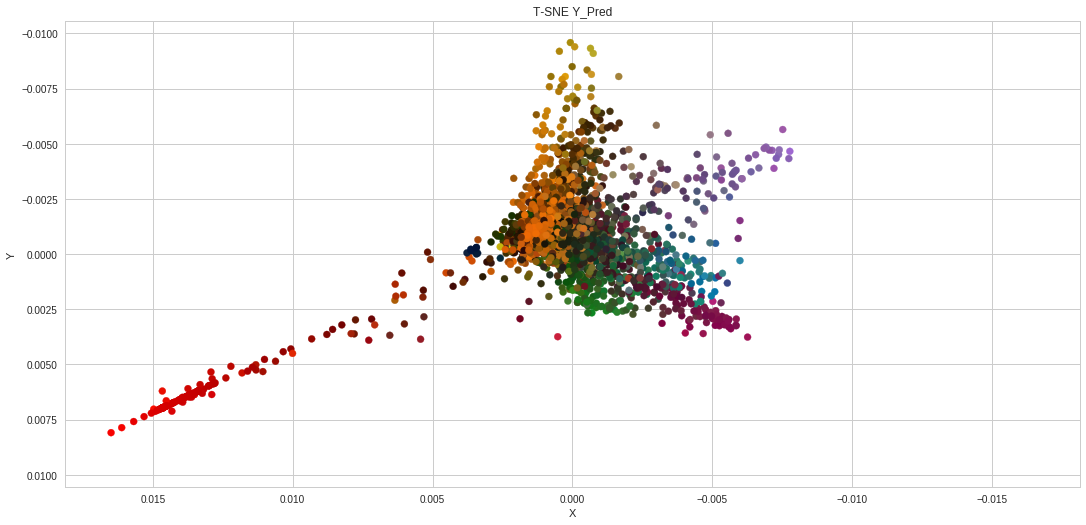

In [36]:
y_pred_colors = np.einsum('ij,jk->ik', y_pred, data_['data_colors'])
y_pred_colors[y_pred_colors>1] = 1
y_pred_colors[y_pred_colors<0] = 0
x = y_pred_z[:,0]
y = y_pred_z[:,1]

y_pred_colors = [tuple(x) for x in y_pred_colors.tolist()]

x_max = max(abs(x))*1.1
y_max = max(abs(y))*1.1

fig = plt.figure(figsize=(15,7))
plt.scatter(x=x, y=y, c=y_pred_colors)
plt.xlim([x_max, -x_max])
plt.ylim([y_max, -y_max])
# plt.autoscale()
plt.tight_layout()
plt.title('T-SNE Y_Pred')
plt.xlabel('X')
plt.ylabel('Y')
plt.savefig('VAE-Conv1D-Y-Pred.svg', format='svg', dpi=1200)

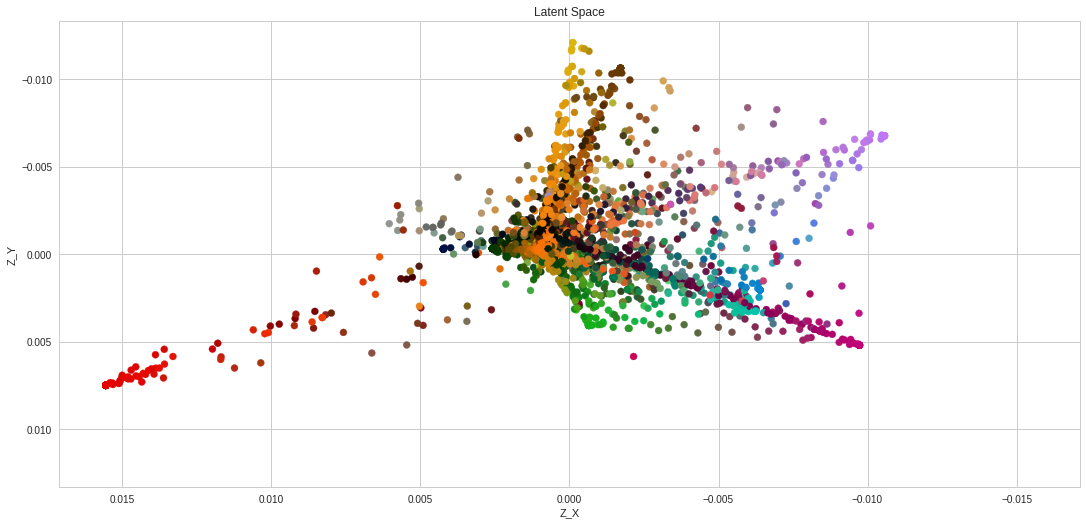

In [39]:
x = y_true_z[:,0]
y = y_true_z[:,1]

x_max = max(abs(x))*1.1
y_max = max(abs(y))*1.1

fig = plt.figure(figsize=(15,7))
plt.scatter(x=x, y=y, c=data_['y_test_c_colors'])
plt.xlim([x_max, -x_max])
plt.ylim([y_max, -y_max])
# plt.autoscale()
plt.tight_layout()
plt.title('Latent Space')
plt.xlabel('Z_X')
plt.ylabel('Z_Y')
plt.savefig('VAE-Conv1D-Y-True.svg', format='svg', dpi=1200)

In [41]:
x_train_encoded_conv = conv_encoder.predict(data_['x_train_c'])
x_test_encoded_conv = conv_encoder.predict(data_['x_test_c'])
print(x_train_encoded_conv.shape)
print(x_test_encoded_conv.shape)
x_encoded = np.concatenate((x_train_encoded_conv,x_test_encoded_conv),axis=0)
print(x_encoded.shape)

(14600, 256)
(3600, 256)
(18200, 256)


## VAE on Conv1D hidden state

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
Input (InputLayer)               (None, 256)           0                                            
____________________________________________________________________________________________________
Encoder_H (Dense)                (None, 64)            16448       Input[0][0]                      
____________________________________________________________________________________________________
mu (Dense)                       (None, 2)             130         Encoder_H[0][0]                  
____________________________________________________________________________________________________
l_sigma (Dense)                  (None, 2)             130         Encoder_H[0][0]                  
___________________________________________________________________________________________

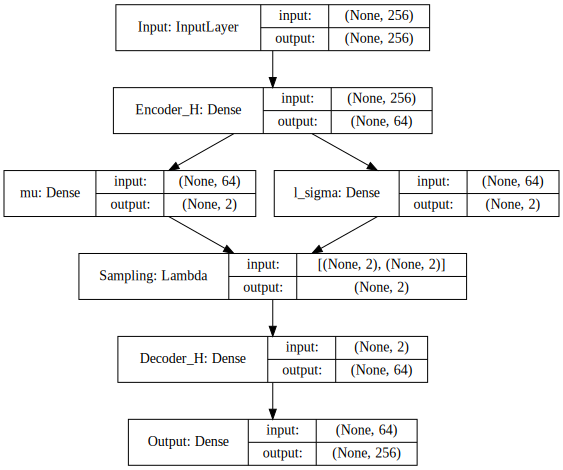

In [47]:
original_dim = data_['x_train_c'].shape[-1]

time_dim = data_['time']
days_dim = data_['days']
latent_dim = 2
intermediate_dim = 10
epochs = 100
batch_size = 20

conv_vae, conv_vae_encoder, conv_vae_generator = buid_cvae(x_encoded.shape[1],
              batch_size = 20,
              latent_dim = 2,
              intermediate_dim = 64,
              activ='relu',
              optim=Adam(lr=0.0005),
              epsilon_std=1.)
print(conv_vae.summary())
SVG(model_to_dot(conv_vae, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [48]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)

conv_vae.fit(x_train_encoded_conv,
             x_train_encoded_conv,
            shuffle=True,
            epochs=epochs,
             verbose=0,
            batch_size=batch_size,
            validation_data=(x_test_encoded_conv,x_test_encoded_conv),
           callbacks=[early_stop,TQDMNotebookCallback(metric_format="{name}: {value:0.4f}")])

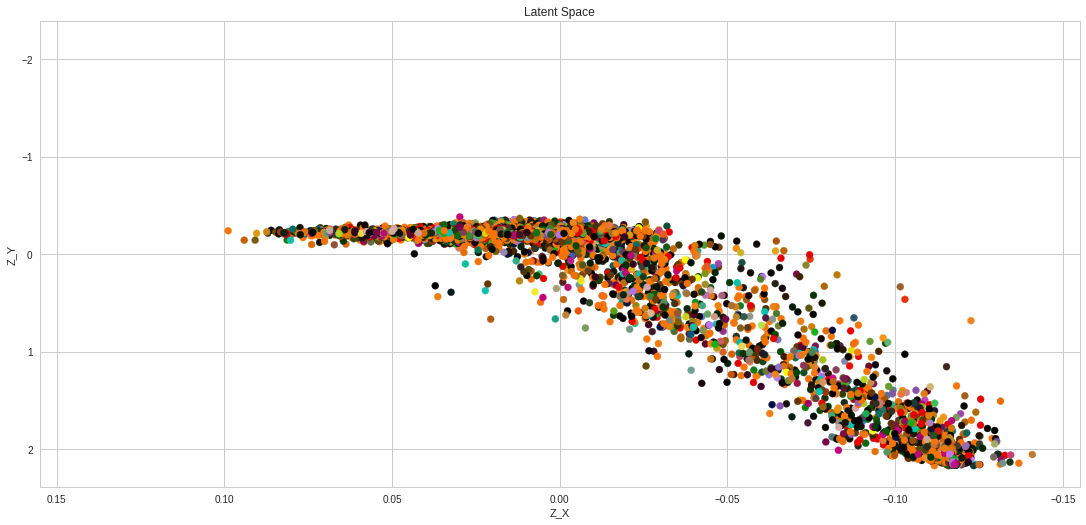

In [49]:
# display a 2D plot of the digit classes in the latent space
conv_vae_encoded = conv_vae_encoder.predict(x_encoded, batch_size=batch_size)


x = conv_vae_encoded[:,0]
y = conv_vae_encoded[:,1]

x_max = max(abs(x))*1.1
y_max = max(abs(y))*1.1
fig = plt.figure(figsize=(15,7))
plt.scatter(x=x, y=y, c=data_['y_test_c_colors'])
plt.xlim([x_max, -x_max])
plt.ylim([y_max, -y_max])
# plt.autoscale()
plt.tight_layout()
plt.title('Latent Space')
plt.xlabel('Z_X')
plt.ylabel('Z_Y')
plt.savefig('VAE-Conv1D-Hidden.svg', format='svg', dpi=1200)

# Analysis
Here it is important to remember that the encoded representation is the summary of the previous window of activity and the label is the next time step
    1. Clusters of the same color therefore signify apps that tend to be used consistently and focused on for extended periods of time
    2. There seem to be 6 gaussians in this latent space signifying this latent distribution is in fact a mixture of Gaussians. Since this latent space is a generative one, we can infer that there exist 6 main modes of app-usage behaviour. Below we visualize the Gaussian Mixtures

In [ ]:
nk=6
kmeans = KMeans(n_clusters=nk).fit(conv_vae_encoded)
gmm_scaled = GaussianMixture(n_components = nk, covariance_type='tied')
gmm_scaled.fit(conv_vae_encoded)
gmm_scaled_labels = gmm_scaled.predict(conv_vae_encoded)

In [ ]:
x = conv_vae_encoded[:,0]
y = conv_vae_encoded[:,1]
t = ['<br>'.join(json.dumps(x).split(',')) for x in data_['y_labels']]
bupu = cl.scales[str(nk)]['div']['RdBu']
c = [bupu[x] for x in kmeans.labels_]
trace1 = go.Scatter(
    x=x,
    y=y, 
    mode='markers',
    marker=dict(color = c, opacity=0.8),
    text = t
)
data = [trace1]
layout = go.Layout(margin=dict(l=0,r=0,b=0,t=0))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='VAE-Conv-Data-GMM')

### Time & Day VAE on Conv1D hidden state

In [ ]:
original_dim = data_['x_train_c'].shape[-1]

time_dim = data_['time']
days_dim = data_['days']
latent_dim = 2
intermediate_dim = 10
epochs = 100
batch_size = 20

conv_vae_td, conv_vae_encoder_td, conv_vae_generator_td = buid_cvae(
    x_encoded.shape[1],
    batch_size = 20,
    latent_dim = 2,
    intermediate_dim = 64,
    intermediate_dim2 = 32,
    activ='relu',
    optim=Adam(lr=0.0005),
    epsilon_std=1.,
    time_dim=time_dim,
    day_dim=days_dim)

In [ ]:
# compile and fit
conv_vae_td_hist = conv_vae_td.fit([x_train_encoded_conv, to_categorical(data_['y_train_d']), to_categorical(data_['y_train_t'])], 
                            x_train_encoded_conv, 
                            verbose = 0, 
                            shuffle=False,
                            batch_size=batch_size, 
                            epochs=epochs,
                            validation_data = (
                                [x_test_encoded_conv, to_categorical(data_['y_test_d']),to_categorical(data_['y_test_t'])], 
                                x_test_encoded_conv),
                            callbacks = [EarlyStopping(patience = 5),
                                         TQDMNotebookCallback(metric_format="{name}: {value:0.4f}")])


In [ ]:
# display a 2D plot of the digit classes in the latent space
conv_vae_encoded_td = conv_vae_encoder_td.predict([x_encoded, to_categorical(data_['yd']), to_categorical(data_['yt'])], batch_size=batch_size)


x = conv_vae_encoded_td[:,0]
y = conv_vae_encoded_td[:,1]
t = ['<br>'.join(json.dumps(x).split(',')) for x in data_['y_labels']]

trace1 = go.Scatter(
    x=x,
    y=y, 
    mode='markers',
    marker=dict(color = data_['yc_colors'], opacity=0.8),
    text = t
)
data = [trace1]
layout = go.Layout(margin=dict(l=0,r=0,b=0,t=0))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='VAE-Conv-Data')

# LSTM, VAE, VAE_TD

In [50]:
inputs = Input(shape=(window_size, original_dim), name='Inputs')
# inputs_masked = Masking(mask_value=0., name='Masking')(inputs)
encoded = LSTM(64, name='LSTM', activation='elu')(inputs)
output = Dense(original_dim, activation='linear')(encoded)

rnn_encoder = Model(inputs, encoded)
rnn_model = Model(inputs, output)

rnn_model.compile(loss='mse', metrics=['mae'], optimizer='rmsprop')
print(rnn_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Inputs (InputLayer)          (None, 6, 15)             0         
_________________________________________________________________
LSTM (LSTM)                  (None, 64)                20480     
_________________________________________________________________
dense_2 (Dense)              (None, 15)                975       
Total params: 21,455
Trainable params: 21,455
Non-trainable params: 0
_________________________________________________________________
None


In [51]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=2, min_lr=0.000001, verbose=0)
rnn_model_hist= rnn_model.fit(
    data_['x_train_c'], 
    data_['y_train_c'], 
    verbose=0, 
    epochs=1000, 
    batch_size=128, 
    validation_data=(data_['x_test_c'], data_['y_test_c']), 
    callbacks=[reduce_lr,
               early_stop,
               TQDMNotebookCallback(metric_format="{name}: {value:0.4f}",leave_outer=True,leave_inner=True)])

In [52]:
y_pred = rnn_model.predict(data_['x_test_c'], batch_size=20)
Y_test = data_['y_test_c']
for i in range(0,Y_test.shape[0],10):
    print("=== Prediction ===", "\n")
    print(np.round(y_pred[i]*300), "\n")
    print("=== True value ===","\n")
    print(np.round(Y_test[i]*300), "\n")

=== Prediction === 

[ 109.    8.    1.   17.    8.    1.   93.    4.    1.    4.    6.   -2.
    0.    4.    6.] 

=== True value === 

[  85.    0.    0.    0.    0.    0.  211.    0.    0.    0.    0.    0.
    0.    0.    4.] 

=== Prediction === 

[ 28.   5.  -0.  15.   3.   7.   3.   7.   4.   0.   2.   1.   0.   2.   8.] 

=== True value === 

[ 39.   0.   0.   0.   0.   0.   0.   0.   6.   0.   0.   0.   0.   0.  27.] 

=== Prediction === 

[ 29.   5.   2.  13.  11.   3.   2.   7.   5.   3.   2.   2.  -2.   2.  17.] 

=== True value === 

[  77.    0.  122.    0.   27.    0.    0.    1.    0.    0.    0.    0.
    0.    0.    0.] 

=== Prediction === 

[   9.    5.  200.    5.    6.    1.   10.    6.   15.    5.   -1.   17.
    1.    0.   16.] 

=== True value === 

[   0.    0.  279.    0.    0.    0.    0.    0.   21.    0.    0.    0.
    0.    0.    0.] 

=== Prediction === 

[   5.    7.  157.    4.    9.   -0.    8.    4.   40.    4.   -1.   38.
   -0.   -2.   15.] 

=== 

[   0.    0.  268.    0.    0.    0.    0.    0.   31.    0.    0.    0.
    0.    0.    0.] 

=== Prediction === 

[  12.    7.  169.    7.    8.    0.    8.    5.   13.    2.    1.   28.
    1.    2.   17.] 

=== True value === 

[  0.   0.   0.  12.   0.   0.  81.   0.  32.   0.   0.   0.   0.   0.   2.] 

=== Prediction === 

[  10.    7.    8.   14.   -7.   11.   17.    4.   22.    5.  158.    3.
    4.   -1.   12.] 

=== True value === 

[   0.    0.    0.    0.    0.    0.   63.    0.    0.    0.  232.    5.
    0.    0.    0.] 

=== Prediction === 

[ 26.   4.  -1.  12.   4.   8.  10.  30.   4.   2.   2.   4.   0.   2.   8.] 

=== True value === 

[  0.   0.   0.   0.   0.   0.   0.   2.   0.   0.   0.   0.   0.   0.  45.] 

=== Prediction === 

[ 27.   9.   2.  13.   2.   7.   9.   6.   5.   1.   2.  -0.   1.   2.  12.] 

=== True value === 

[ 42.   0.   0.   0.   0.   0.   0.   0.   6.   0.   0.   0.   0.   0.   4.] 

=== Prediction === 

[ 29.   6.  -0.  14.   3.  10.   4. 

=== True value === 

[   0.    0.    0.    0.    0.    0.    0.    0.    0.   11.    0.    0.
    0.    0.  289.] 

=== Prediction === 

[  19.    5.   29.    2.    1.    2.    5.    4.   12.    6.    0.    3.
    0.   -0.  131.] 

=== True value === 

[   0.    0.   13.    0.    0.    0.    0.    0.    0.   38.    2.    0.
    0.    0.  247.] 

=== Prediction === 

[   4.    6.  183.   16.    9.    0.    9.    8.    2.    6.    3.   20.
    2.    0.   33.] 

=== True value === 

[   0.    0.  210.    0.    0.   16.    0.    2.   66.    0.    0.    0.
    0.    0.    6.] 

=== Prediction === 

[ 28.   5.   0.  15.   3.   7.   3.   7.   4.   0.   2.   1.   0.   1.  10.] 

=== True value === 

[ 0.  0.  0.  0.  0.  0.  0.  0.  2.  0.  0.  0.  0.  0.  6.] 

=== Prediction === 

[ 28.   5.  -0.  15.   3.   7.   3.   7.   4.   0.   2.   1.   0.   2.   8.] 

=== True value === 

[  0.   0.   0.   0.   0.  28.   0.   0.   4.   0.   0.   0.   0.   0.   1.] 

=== Prediction === 

[  17.  154.  

    0.    0.   16.] 

=== Prediction === 

[  10.    7.  212.    6.    3.   -1.    8.    4.    6.    4.   -4.    8.
    0.   -2.   20.] 

=== True value === 

[   0.    0.  300.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.] 

=== Prediction === 

[ 27.   6.   1.  14.   0.   5.   2.   8.   6.   3.   2.   2.  -3.   2.  15.] 

=== True value === 

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  3.] 

=== Prediction === 

[ 26.   4.   0.  29.   2.   6.   4.   6.   5.   1.  38.   0.   1.   1.   8.] 

=== True value === 

[ 153.    0.    0.   34.    0.    0.    0.    0.   13.    0.    0.    0.
    0.    0.    4.] 

=== Prediction === 

[ 27.   5.   0.  15.   3.   7.   3.   7.   4.   0.   2.   1.   0.   1.  10.] 

=== True value === 

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  18.] 

=== Prediction === 

[  14.   -2.  150.   13.   15.   -2.    9.    6.    7.    4.    4.   19.
    0.    4.   12.] 

=== True value === 

[   0.  

(3600, 2) (3600, 2)


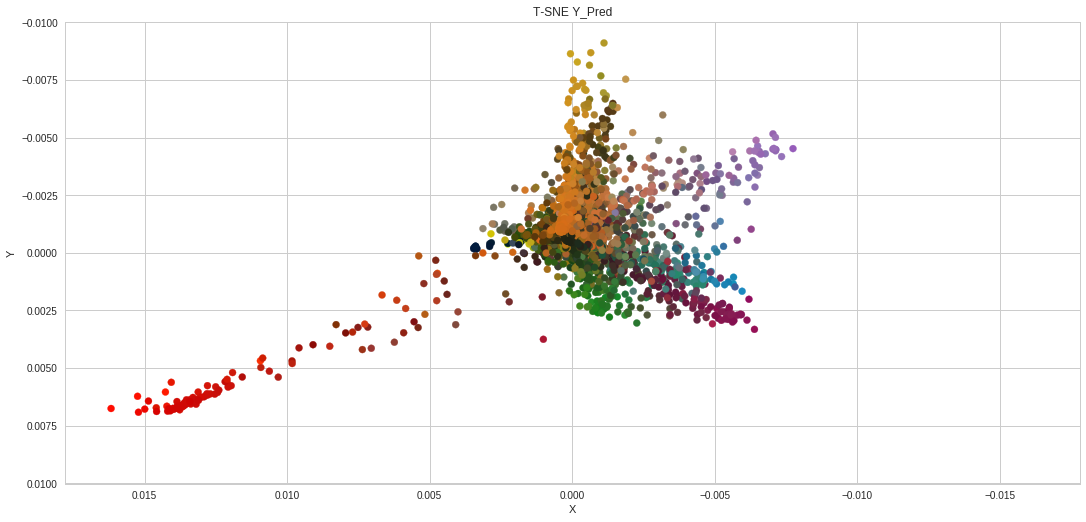

In [54]:
y_pred_z = encoder.predict(y_pred, batch_size=100)
y_true_z = encoder.predict(Y_test, batch_size=100)
print(y_pred_z.shape, y_true_z.shape)

# plt.figure(figsize=(7, 7))
# plt.scatter(encodings[:, 0], encodings[:, 1], c=data_['yc_colors'])
# plt.show()

y_pred_colors = np.einsum('ij,jk->ik', y_pred, data_['data_colors'])
y_pred_colors[y_pred_colors>1] = 1
y_pred_colors[y_pred_colors<0] = 0
x = y_pred_z[:,0]
y = y_pred_z[:,1]

y_pred_colors = [tuple(x) for x in y_pred_colors.tolist()]

x_max = max(abs(x))*1.1
y_max = max(abs(y))*1.1

fig = plt.figure(figsize=(15,7))
plt.scatter(x=x, y=y, c=y_pred_colors)
plt.xlim([x_max, -x_max])
plt.ylim([y_max, -y_max])
# plt.autoscale()
plt.tight_layout()
plt.title('T-SNE Y_Pred')
plt.xlabel('X')
plt.ylabel('Y')
plt.savefig('VAE-LSTM-Y-Pred.svg', format='svg', dpi=1200)

In [ ]:
# y_pred_colors = convert_to_rgb(np.einsum('ij,jk->ik', y_pred, data_['cmap']))
x = y_true_z[:,0]
y = y_true_z[:,1]
t = ['<br>'.join(json.dumps(x).split(',')) for x in data_['y_test_labels']]

trace1 = go.Scatter(
    x=x,
    y=y, 
    mode='markers',
    marker=dict(color = data_['y_test_c_colors'], opacity=0.8),
    text = t
)
data = [trace1]
layout = go.Layout(margin=dict(l=0,r=0,b=0,t=0))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='VAE-Data')

# End-To-End LSTM/Conv1D + VAE

# Pre-Train LSTM VAE, MLP VAE, then End-To-End LSTM-VAE

In [7]:
print(data_['x_train_c'].shape)
latent_x_train = list()
for i in range(6):
    latent_x_train.append(encoder.predict(data_['x_train_c'][:,i,:]))
latent_x_train = np.asarray(latent_x_train)
latent_x_train = latent_x_train.reshape(latent_x_train.shape[1], latent_x_train.shape[0], latent_x_train.shape[2])
print(latent_x_train.shape)


print(data_['x_test_c'].shape)
latent_x_test = list()
for i in range(6):
    latent_x_test.append(encoder.predict(data_['x_test_c'][:,i,:]))
latent_x_test = np.asarray(latent_x_test)
latent_x_test = latent_x_test.reshape(latent_x_test.shape[1], latent_x_test.shape[0], latent_x_test.shape[2])
print(latent_x_test.shape)


latent_y_train = encoder.predict(data_['y_train_c'])
latent_y_test = encoder.predict(data_['y_test_c'])

print(latent_y_train.shape)
print(latent_y_test.shape)

(14600, 6, 15)
(14600, 6, 2)
(3600, 6, 15)
(3600, 6, 2)
(14600, 2)
(3600, 2)


In [9]:
hidden = 16

inputs = Input(shape=(window_size, 2), name='Inputs')
encoded = LSTM(hidden, name='LSTM', activation='elu')(inputs)
lstm_output = Dense(7, name='Dense', activation='elu')(encoded)
lstm_output = Dense(original_dim, name='Dense2', activation='linear')(lstm_output)

latent_lstm = Model(inputs,lstm_output)
latent_lstm.compile(optimizer='rmsprop', loss='mse')
print(latent_lstm.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Inputs (InputLayer)          (None, 6, 2)              0         
_________________________________________________________________
LSTM (LSTM)                  (None, 16)                1216      
_________________________________________________________________
Dense (Dense)                (None, 7)                 119       
_________________________________________________________________
Dense2 (Dense)               (None, 15)                120       
Total params: 1,455
Trainable params: 1,455
Non-trainable params: 0
_________________________________________________________________
None


In [11]:
latent_lstm.fit(x=latent_x_train,
               y=data_['y_train_c'],
               verbose=2,
               batch_size=batch_size,
               epochs=1000, 
               validation_data=(latent_x_test, data_['y_test_c']), 
    callbacks=[EarlyStopping(patience=5)])

Train on 14600 samples, validate on 3600 samples
Epoch 1/1000
2s - loss: 0.0240 - val_loss: 0.0311
Epoch 2/1000
1s - loss: 0.0238 - val_loss: 0.0311
Epoch 3/1000
1s - loss: 0.0238 - val_loss: 0.0312
Epoch 4/1000
1s - loss: 0.0238 - val_loss: 0.0309
Epoch 5/1000
1s - loss: 0.0238 - val_loss: 0.0310
Epoch 6/1000
1s - loss: 0.0238 - val_loss: 0.0310
Epoch 7/1000
1s - loss: 0.0238 - val_loss: 0.0311
Epoch 8/1000
1s - loss: 0.0238 - val_loss: 0.0311
Epoch 9/1000
1s - loss: 0.0238 - val_loss: 0.0313
Epoch 10/1000
1s - loss: 0.0238 - val_loss: 0.0312


# Convert all data to Z using VAE, Train LSTM, Decode

### Compare all above on prediction-in-std-range metric while training on MSE loss

In [ ]:
1 - show loss for latent=2/3/4/5 (show VAE loss)
2 - show graph of prediction vs timesteps
3 - Justify why VAE is normal
4 - concrete number on how predictable I am
5 - show accuracy vs data size